In [1]:
import patsy
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize
from scipy.integrate import quad
from findpeaks import findpeaks
from quadprog import solve_qp

In [2]:
from module.auto_peak_valley import Peak_Valley_Simu, IsotonicReg, constrained_splines_reg, comprehensive_csr
from module.knot_func import *

### 模擬用的函式 $ sin(4\pi x) $

In [3]:
def f(x):
    return np.sin(4*np.pi*x)

In [4]:
np.random.seed(42)
x = np.linspace(0, 1, 1000).round(5)
y = f(x) + np.random.normal(scale=0.3, size=(1000,))

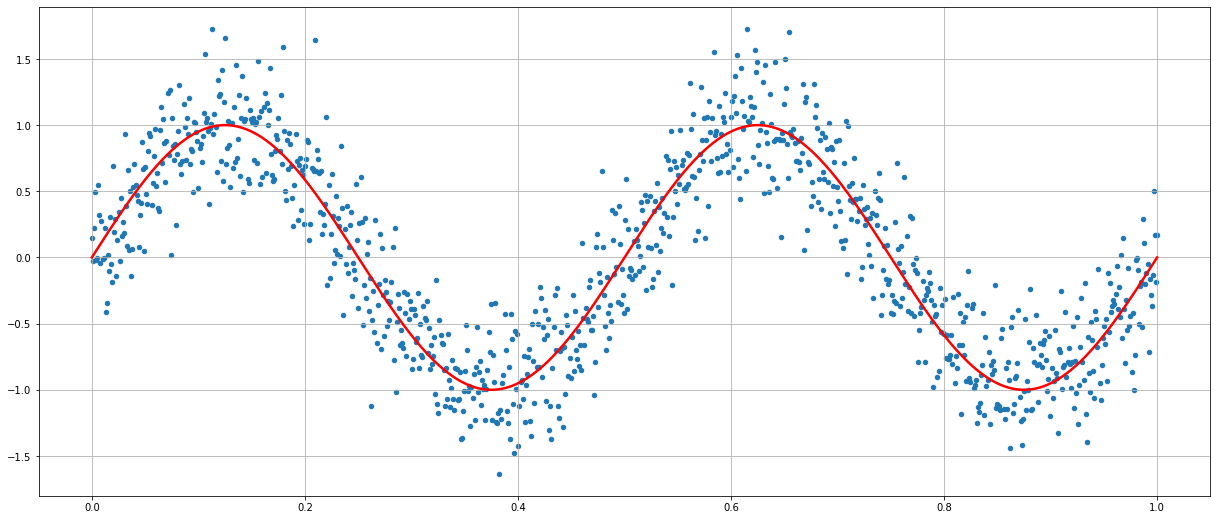

In [5]:
plt.figure(figsize=(21, 9))
plt.scatter(x, y, s=20)
plt.plot(x, f(x), c="r", linewidth=2.5)
plt.grid()
plt.show()

### 使用自己的方法找峰谷位置

In [6]:
multi_peak = Peak_Valley_Simu()
multi_peak.x, multi_peak.y = x, y

In [7]:
auto_multi_init_demarcation, auto_multi_peak_detection_result, auto_multi_peak_detection_dict = \
    multi_peak.auto_peak_points_detection_v3(step=0.02, distance=0.1, iter_scale=1)
print("峰座標：", auto_multi_peak_detection_result)
print(auto_multi_init_demarcation)

auto_multi_initvalley_demarcation, auto_multi_valley_detection_result, auto_multi_valley_detection_dict = \
    multi_peak.auto_valley_points_detection(step=0.02, distance=0.1, iter_scale=1)
print("谷座標：", auto_multi_valley_detection_result)
# print(auto_multi_initvalley_demarcation)

峰座標： deque([0.12012, 0.5996])
deque([0.12012], maxlen=1)
谷座標： deque([0.38038, 0.87988])


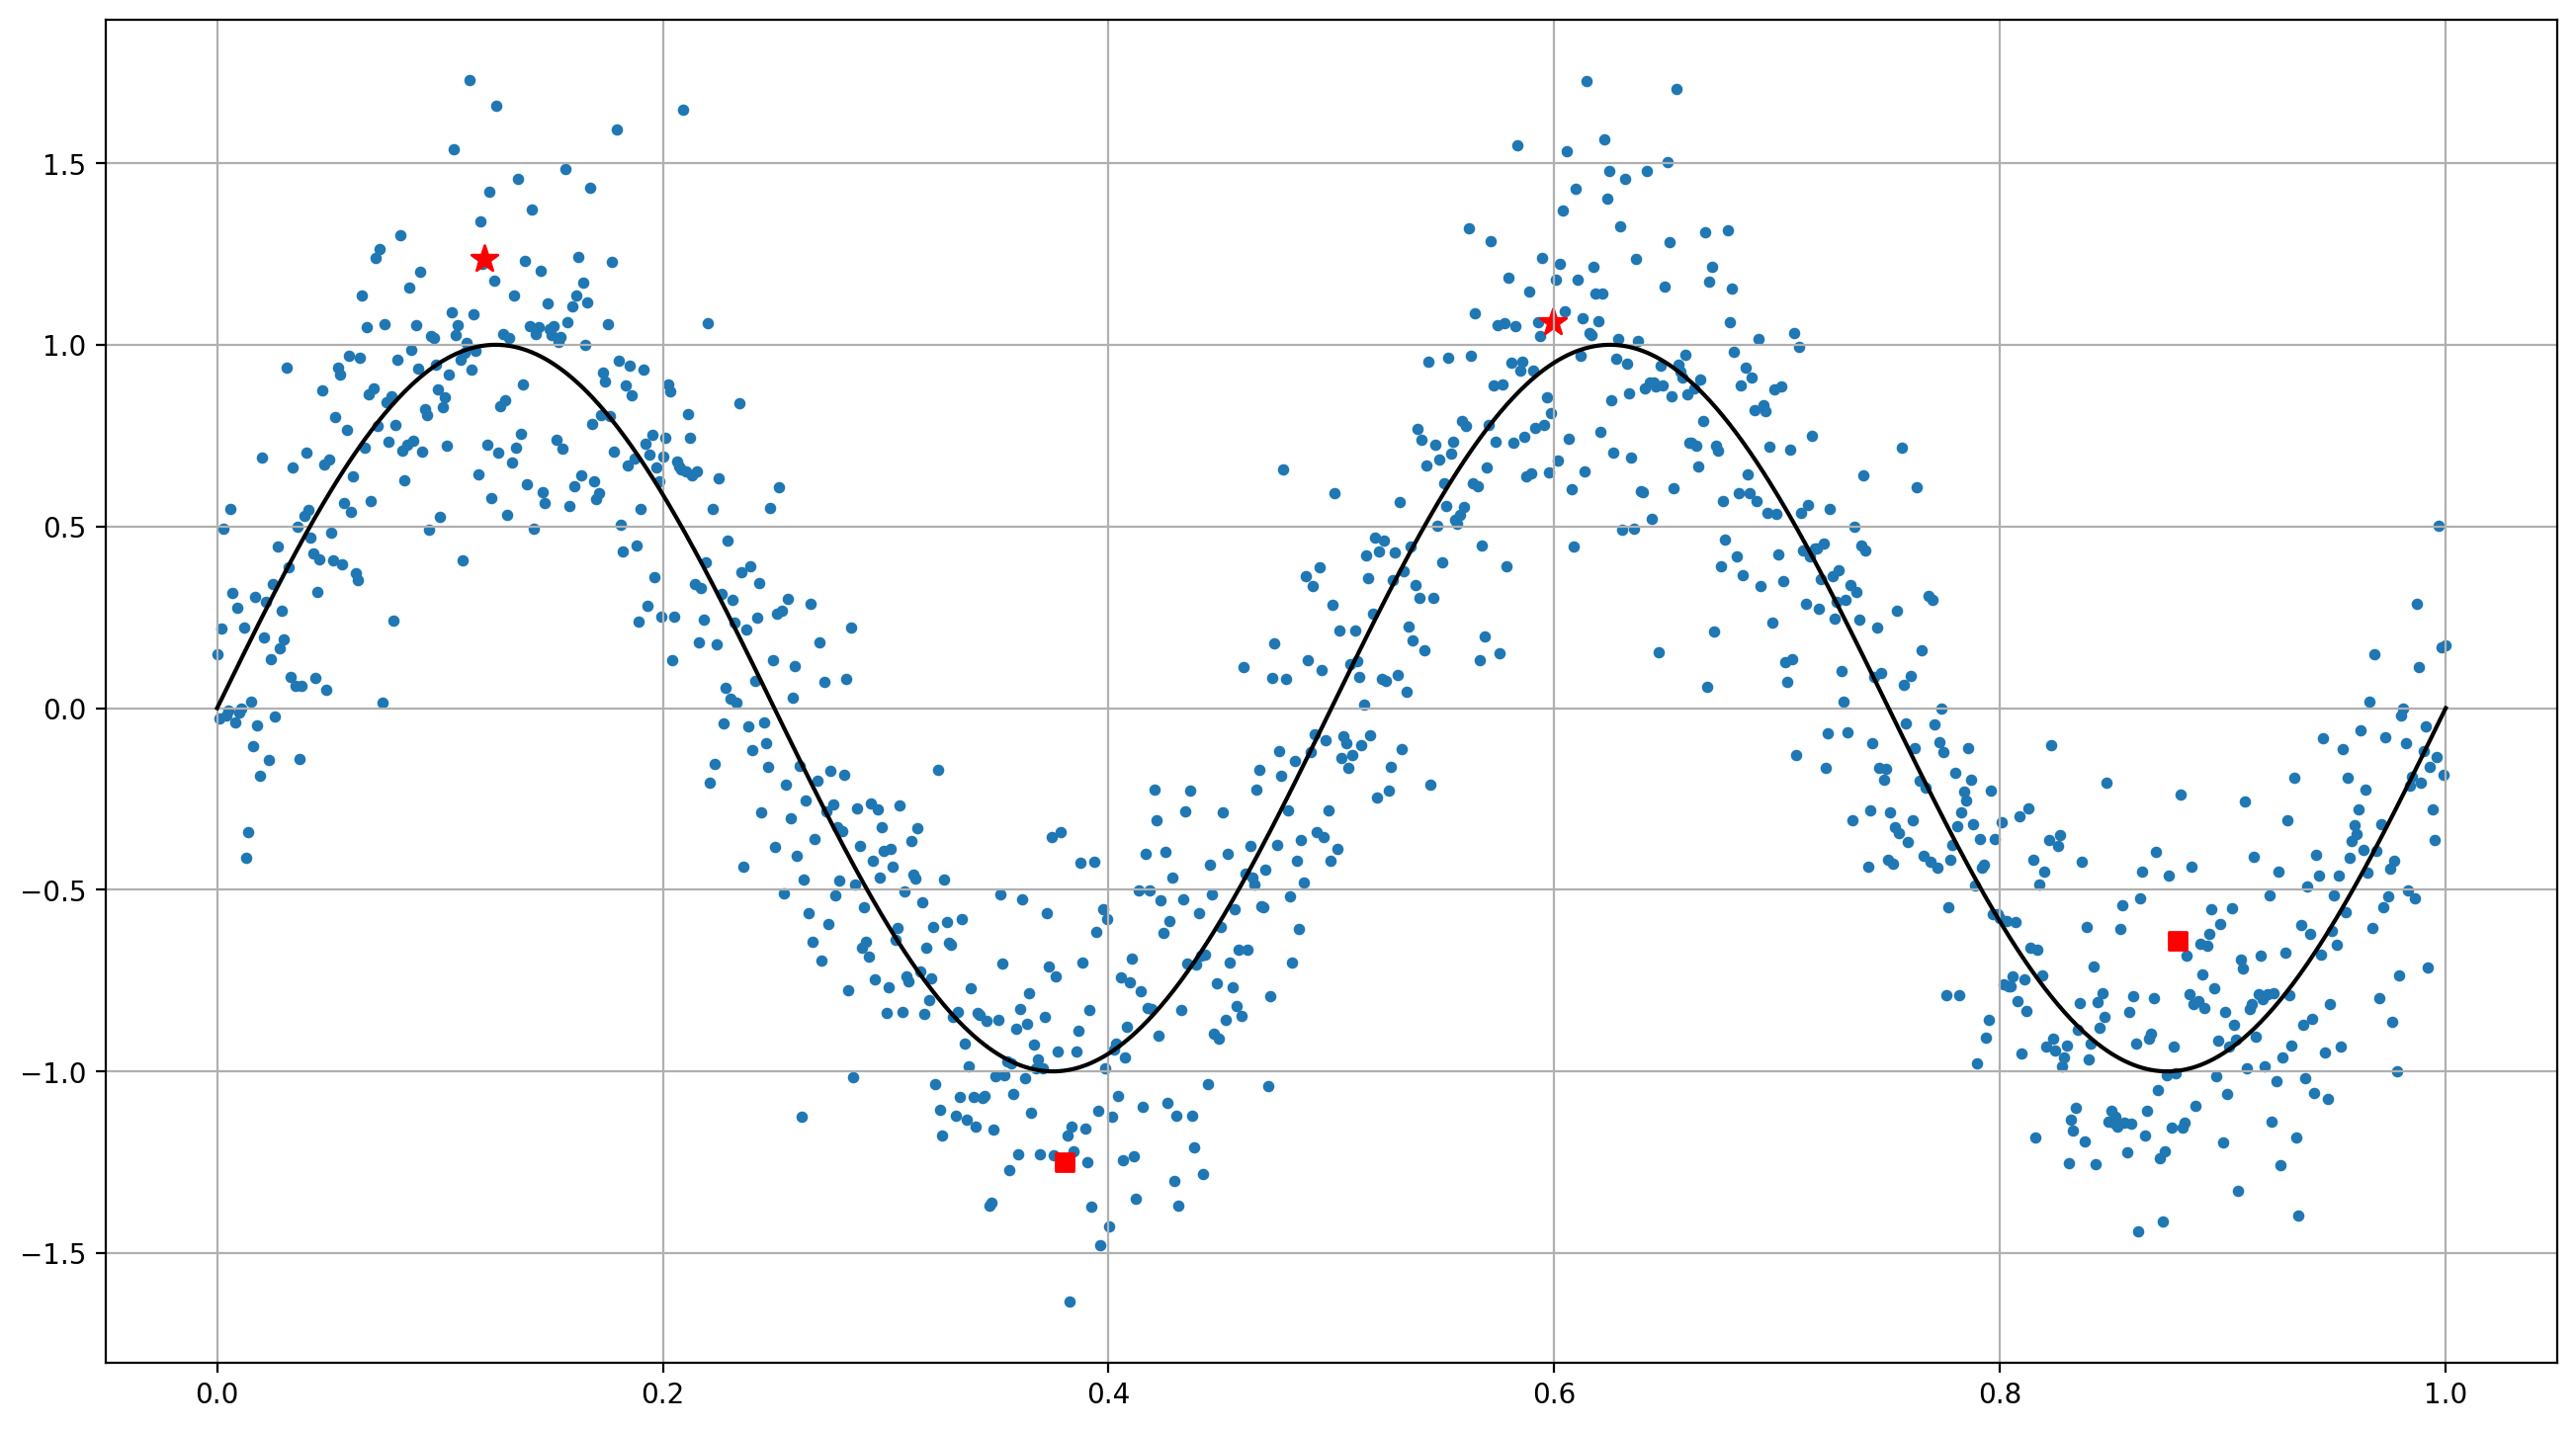

In [8]:
peak_x = list(auto_multi_peak_detection_result)
peak_y = y[[x.tolist().index(i) for i in peak_x]]
valley_x = list(auto_multi_valley_detection_result)
valley_y = y[[x.tolist().index(i) for i in valley_x]]
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(peak_x, peak_y, s=100, c="r", marker='*')
plt.scatter(valley_x, valley_y, s=45, c="r", marker='s')
plt.grid()
plt.show()

In [9]:
def to_softmax_v2(pv_coordinate: list): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_copy = np.array(pv_coordinate)
    output = pv_coordinate_copy / sum(pv_coordinate_copy)
    return output # array

def reverse_softmax_v2(pv_coordinate_softmax_form, x=x): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_original_form = 0.12012*(1/pv_coordinate_softmax_form[0])*pv_coordinate_softmax_form
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

def to_softmax_v3(pv_coordinate, base=0): # 最終版的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv_coordinate), x[-1]))
    pv_coordinate_copy2 = np.diff(pv_coordinate_copy)
    log_odds = np.log(pv_coordinate_copy2 / pv_coordinate_copy2[base])
    return log_odds

def reverse_softmax_v3(pv_coordinate_softmax_form): # 最終版的 multi-class logistic reg 作法
    # pv_coordinate_original_form = np.exp(pv_coordinate_softmax_form) * 0.24024
    # pv_coordinate_original_form = pv_coordinate_original_form.cumsum()[:-1]
    pv_coordinate_base_form = 1 / np.sum(np.exp(pv_coordinate_softmax_form))
    pv_coordinate_original_form = np.hstack((pv_coordinate_base_form, pv_coordinate_base_form*np.exp(pv_coordinate_softmax_form[1:]))).cumsum()
    pv_coordinate_original_form = pv_coordinate_original_form[:-1]
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

In [10]:
pv, pv_index = multi_peak.peak_valley_index()
pv_coordinate_softmax_transform = to_softmax_v2(pv)
print("峰谷座標：", pv, "\n", "峰谷索引：", pv_index, sep="")
print("-"*50)
print("轉換後座標：", pv_coordinate_softmax_transform)

峰谷座標：[0.12012, 0.38038, 0.5996, 0.87988]
峰谷索引：[0, 120, 380, 599, 879, 999]
--------------------------------------------------
轉換後座標： [0.06066728 0.19211305 0.30283134 0.44438833]


In [11]:
print(reverse_softmax_v2(pv_coordinate_softmax_transform))

[0, 120, 380, 599, 879, 999]


RSS:  72.49003856477587


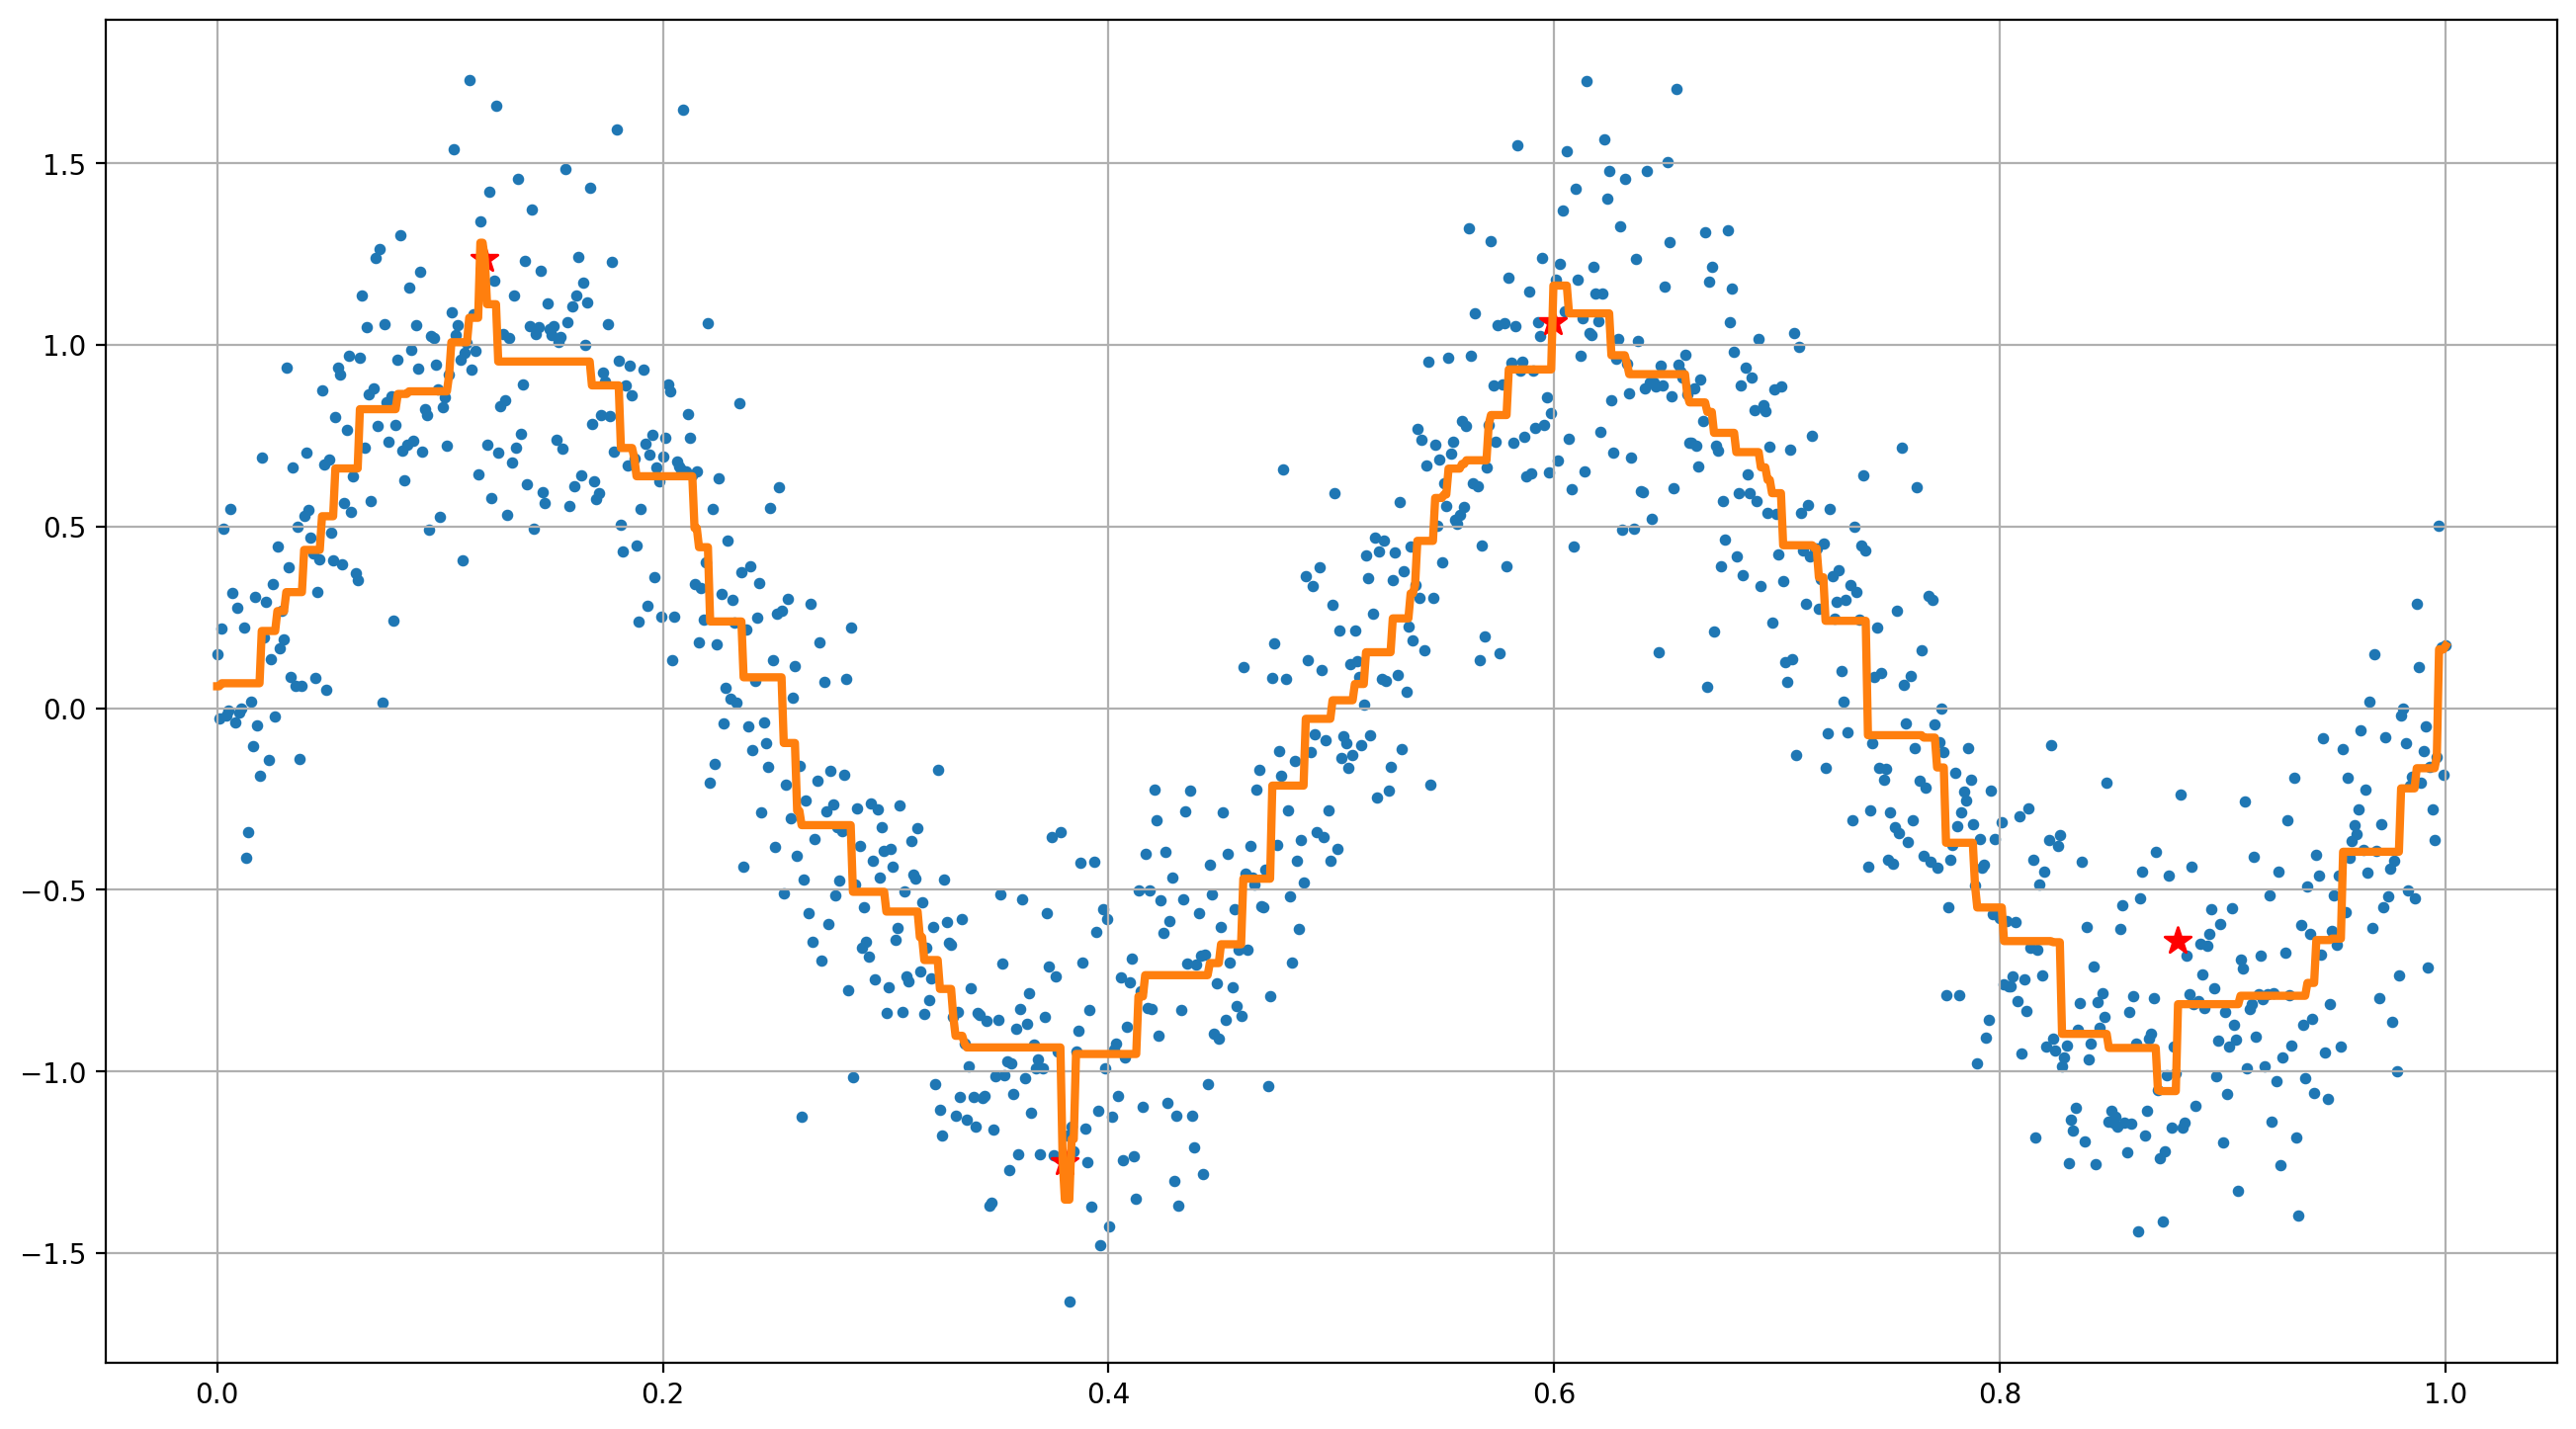

In [12]:
multi_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=pv_index)
multi_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_pv_isoreg.isotonic_rss())
multi_pv_isoreg.plot_isoreg()

In [13]:
# minimize_result = minimize(multi_peak.isotonic_reg_rss_v2, pv_coordinate_softmax_transform, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_simulation2_x", minimize_result.x)

In [14]:
minimize_result = np.load(".\\weights\\minimize_simulation2_x.npy")
print(minimize_result)

[0.0608789  0.19358556 0.3114586  0.44219564]


In [15]:
new_pv = x[reverse_softmax_v2(minimize_result)]
new_pv_index = reverse_softmax_v2(minimize_result)
print(new_pv)
print(new_pv_index)

[0.      0.12012 0.38238 0.61461 0.87287 1.     ]
[0, 120, 382, 614, 872, 999]


In [16]:
pv_coordinate_softmax_v3 = to_softmax_v3(new_pv[1:-1])
print(pv_coordinate_softmax_v3)
print(reverse_softmax_v3(pv_coordinate_softmax_v3))

[0.         0.78084513 0.65923702 0.76547559 0.05671894]
[0, 120, 382, 614, 872, 999]


In [17]:
# minimize_result2 = minimize(multi_peak.isotonic_reg_rss_v3, pv_coordinate_softmax_v3, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_simulation2_1_x", minimize_result2.x)

In [18]:
minimize_result2 = np.load(".\\weights\\minimize_simulation2_1_x.npy")
print(minimize_result2)

[0.         0.78084513 0.65923702 0.76547559 0.05671894]


In [19]:
new_pv2 = x[reverse_softmax_v3(minimize_result2)]
new_pv_index2 = reverse_softmax_v3(minimize_result2)
print(new_pv2)
print(new_pv_index2)
# 原本轉或後優化再使用softmax轉換優或結果相同

[0.      0.12012 0.38238 0.61461 0.87287 1.     ]
[0, 120, 382, 614, 872, 999]


In [20]:
# print(list(zip(x[606:620], y[606:620])))

In [21]:
tmp_new_pv = new_pv.copy()
tmp_new_pv[1], tmp_new_pv[3] = x[124], x[616] #115
tmp_new_pv_index = new_pv_index.copy()
tmp_new_pv_index[1], tmp_new_pv_index[3] = 124, 616 #1115

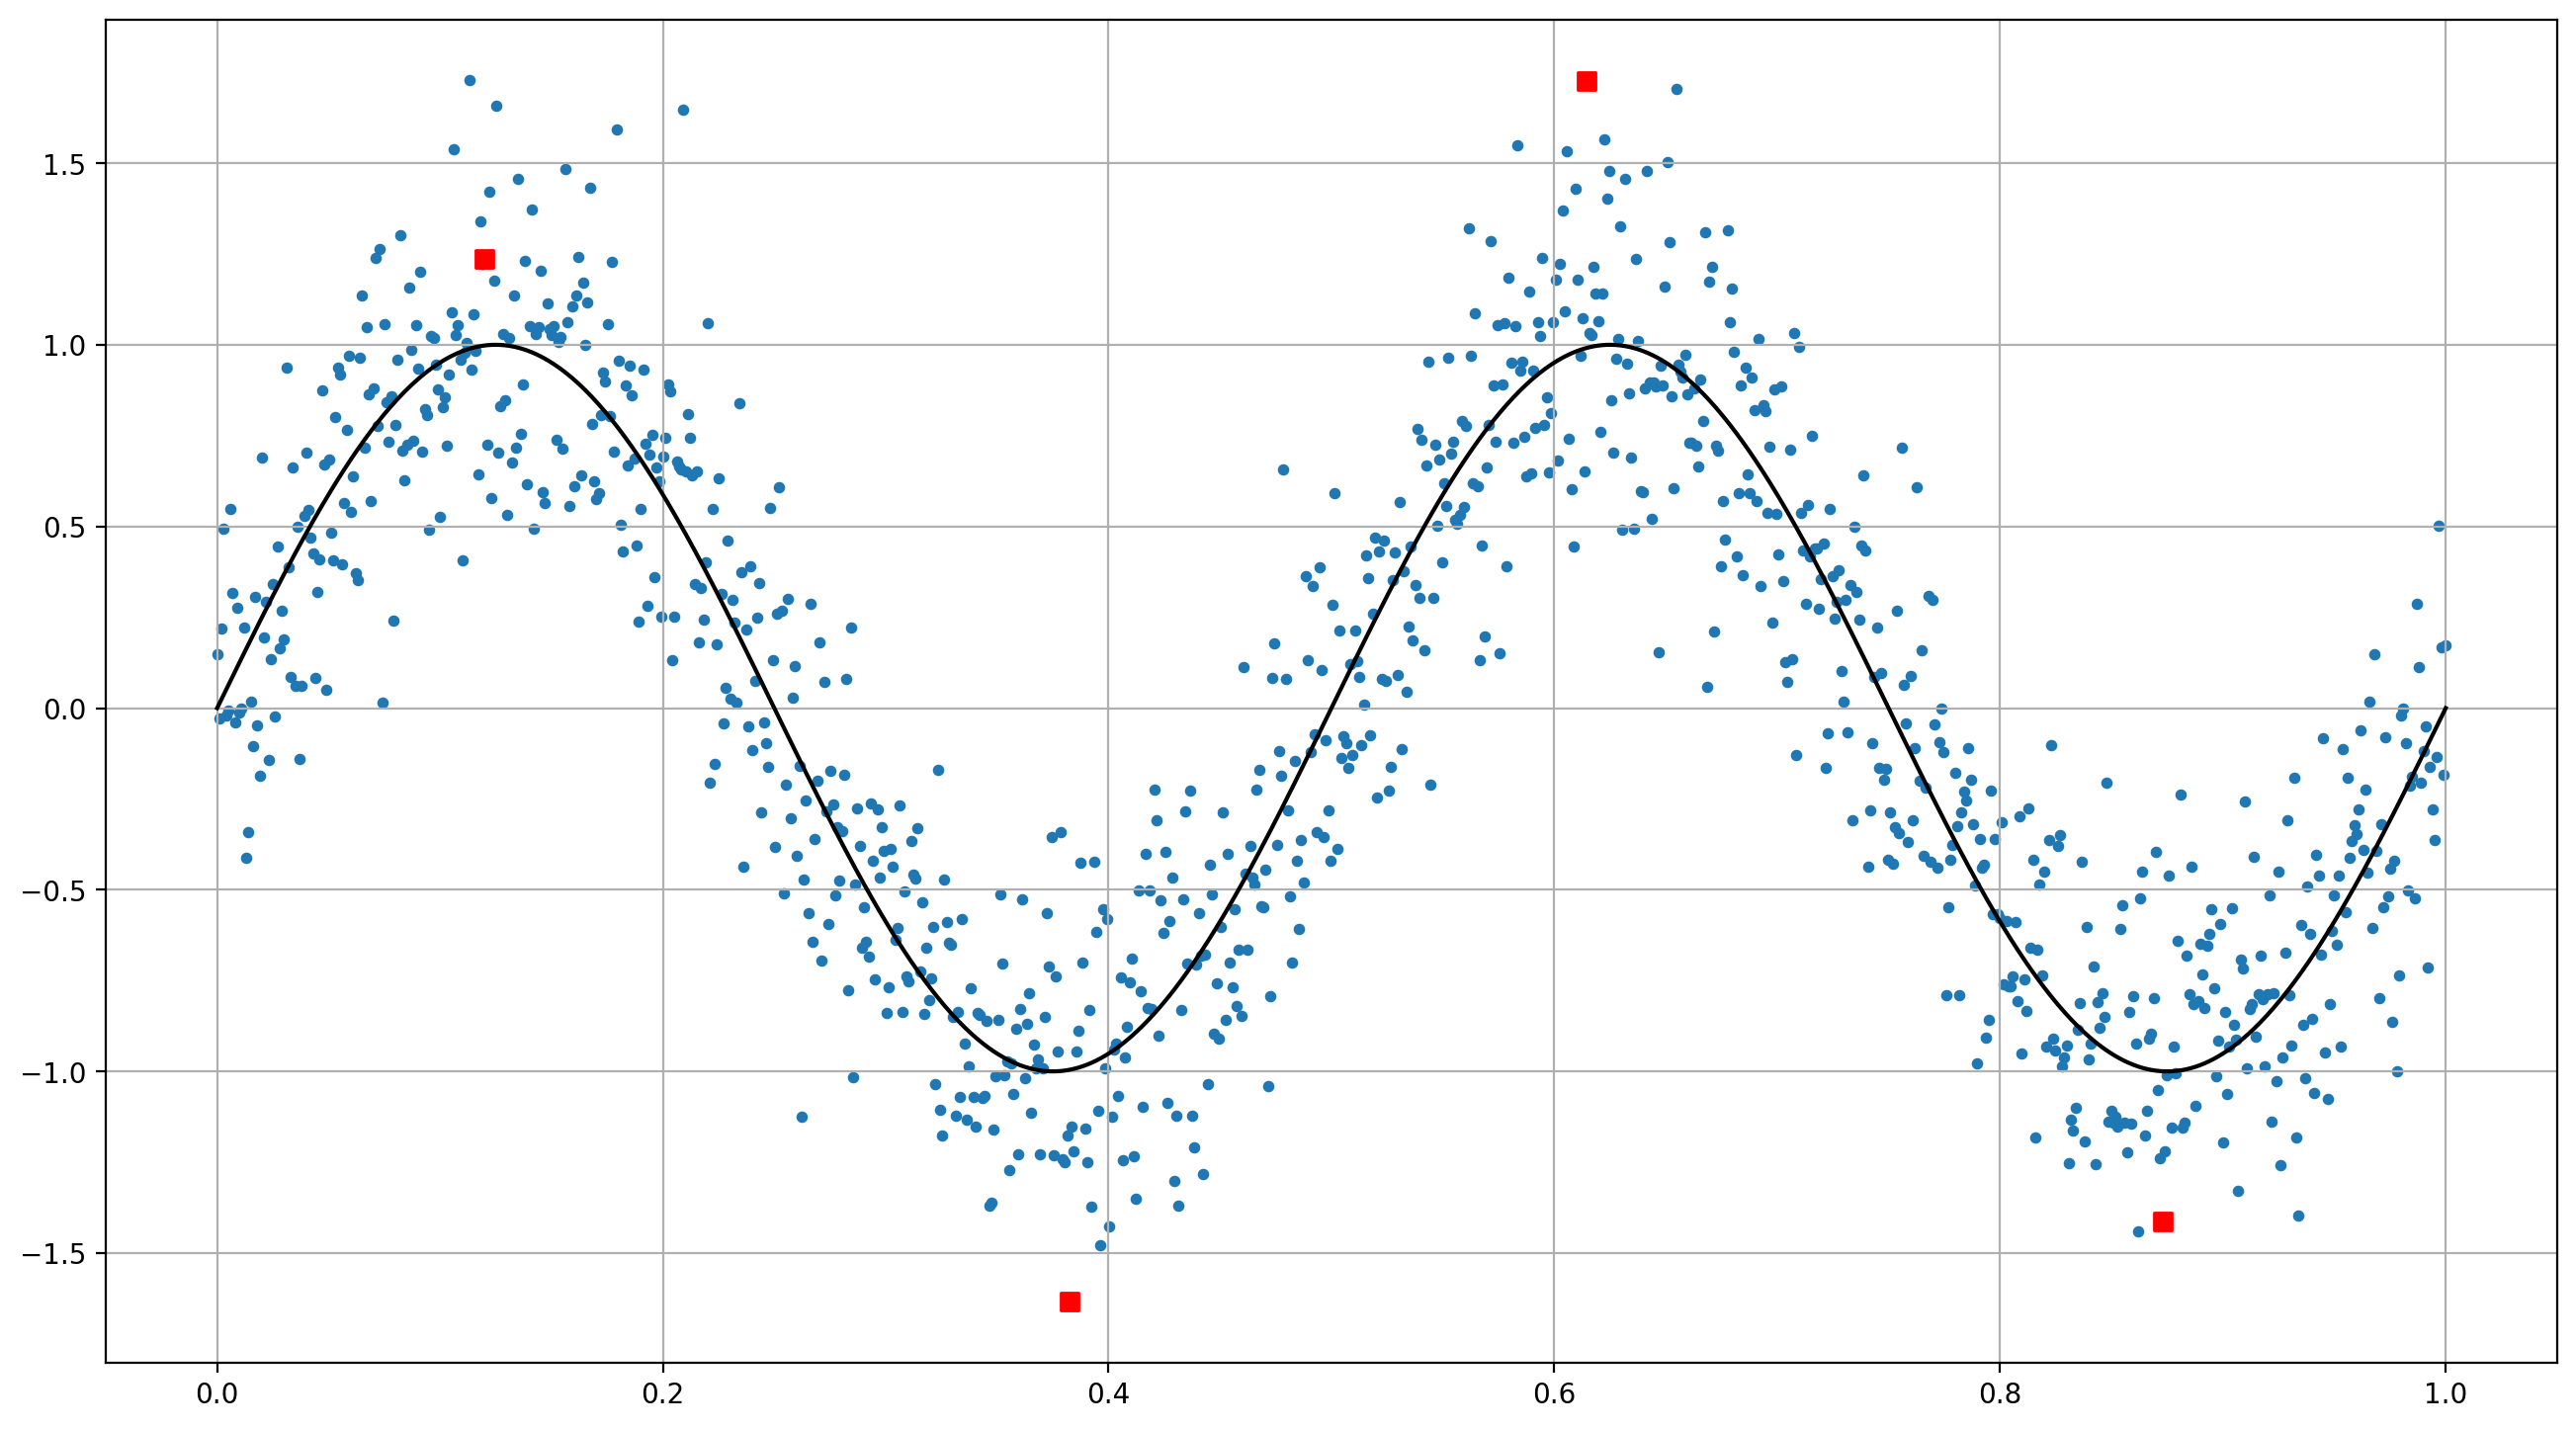

In [22]:
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[new_pv_index[1:-1]], y[new_pv_index[1:-1]], s=45, c="r", marker='s')
# plt.scatter(x[124], y[124], s=45, c="r", marker='s')
# plt.scatter(x[616], y[616], s=45, c="r", marker='s')
plt.grid()
plt.show()

RSS:  71.51890702518185


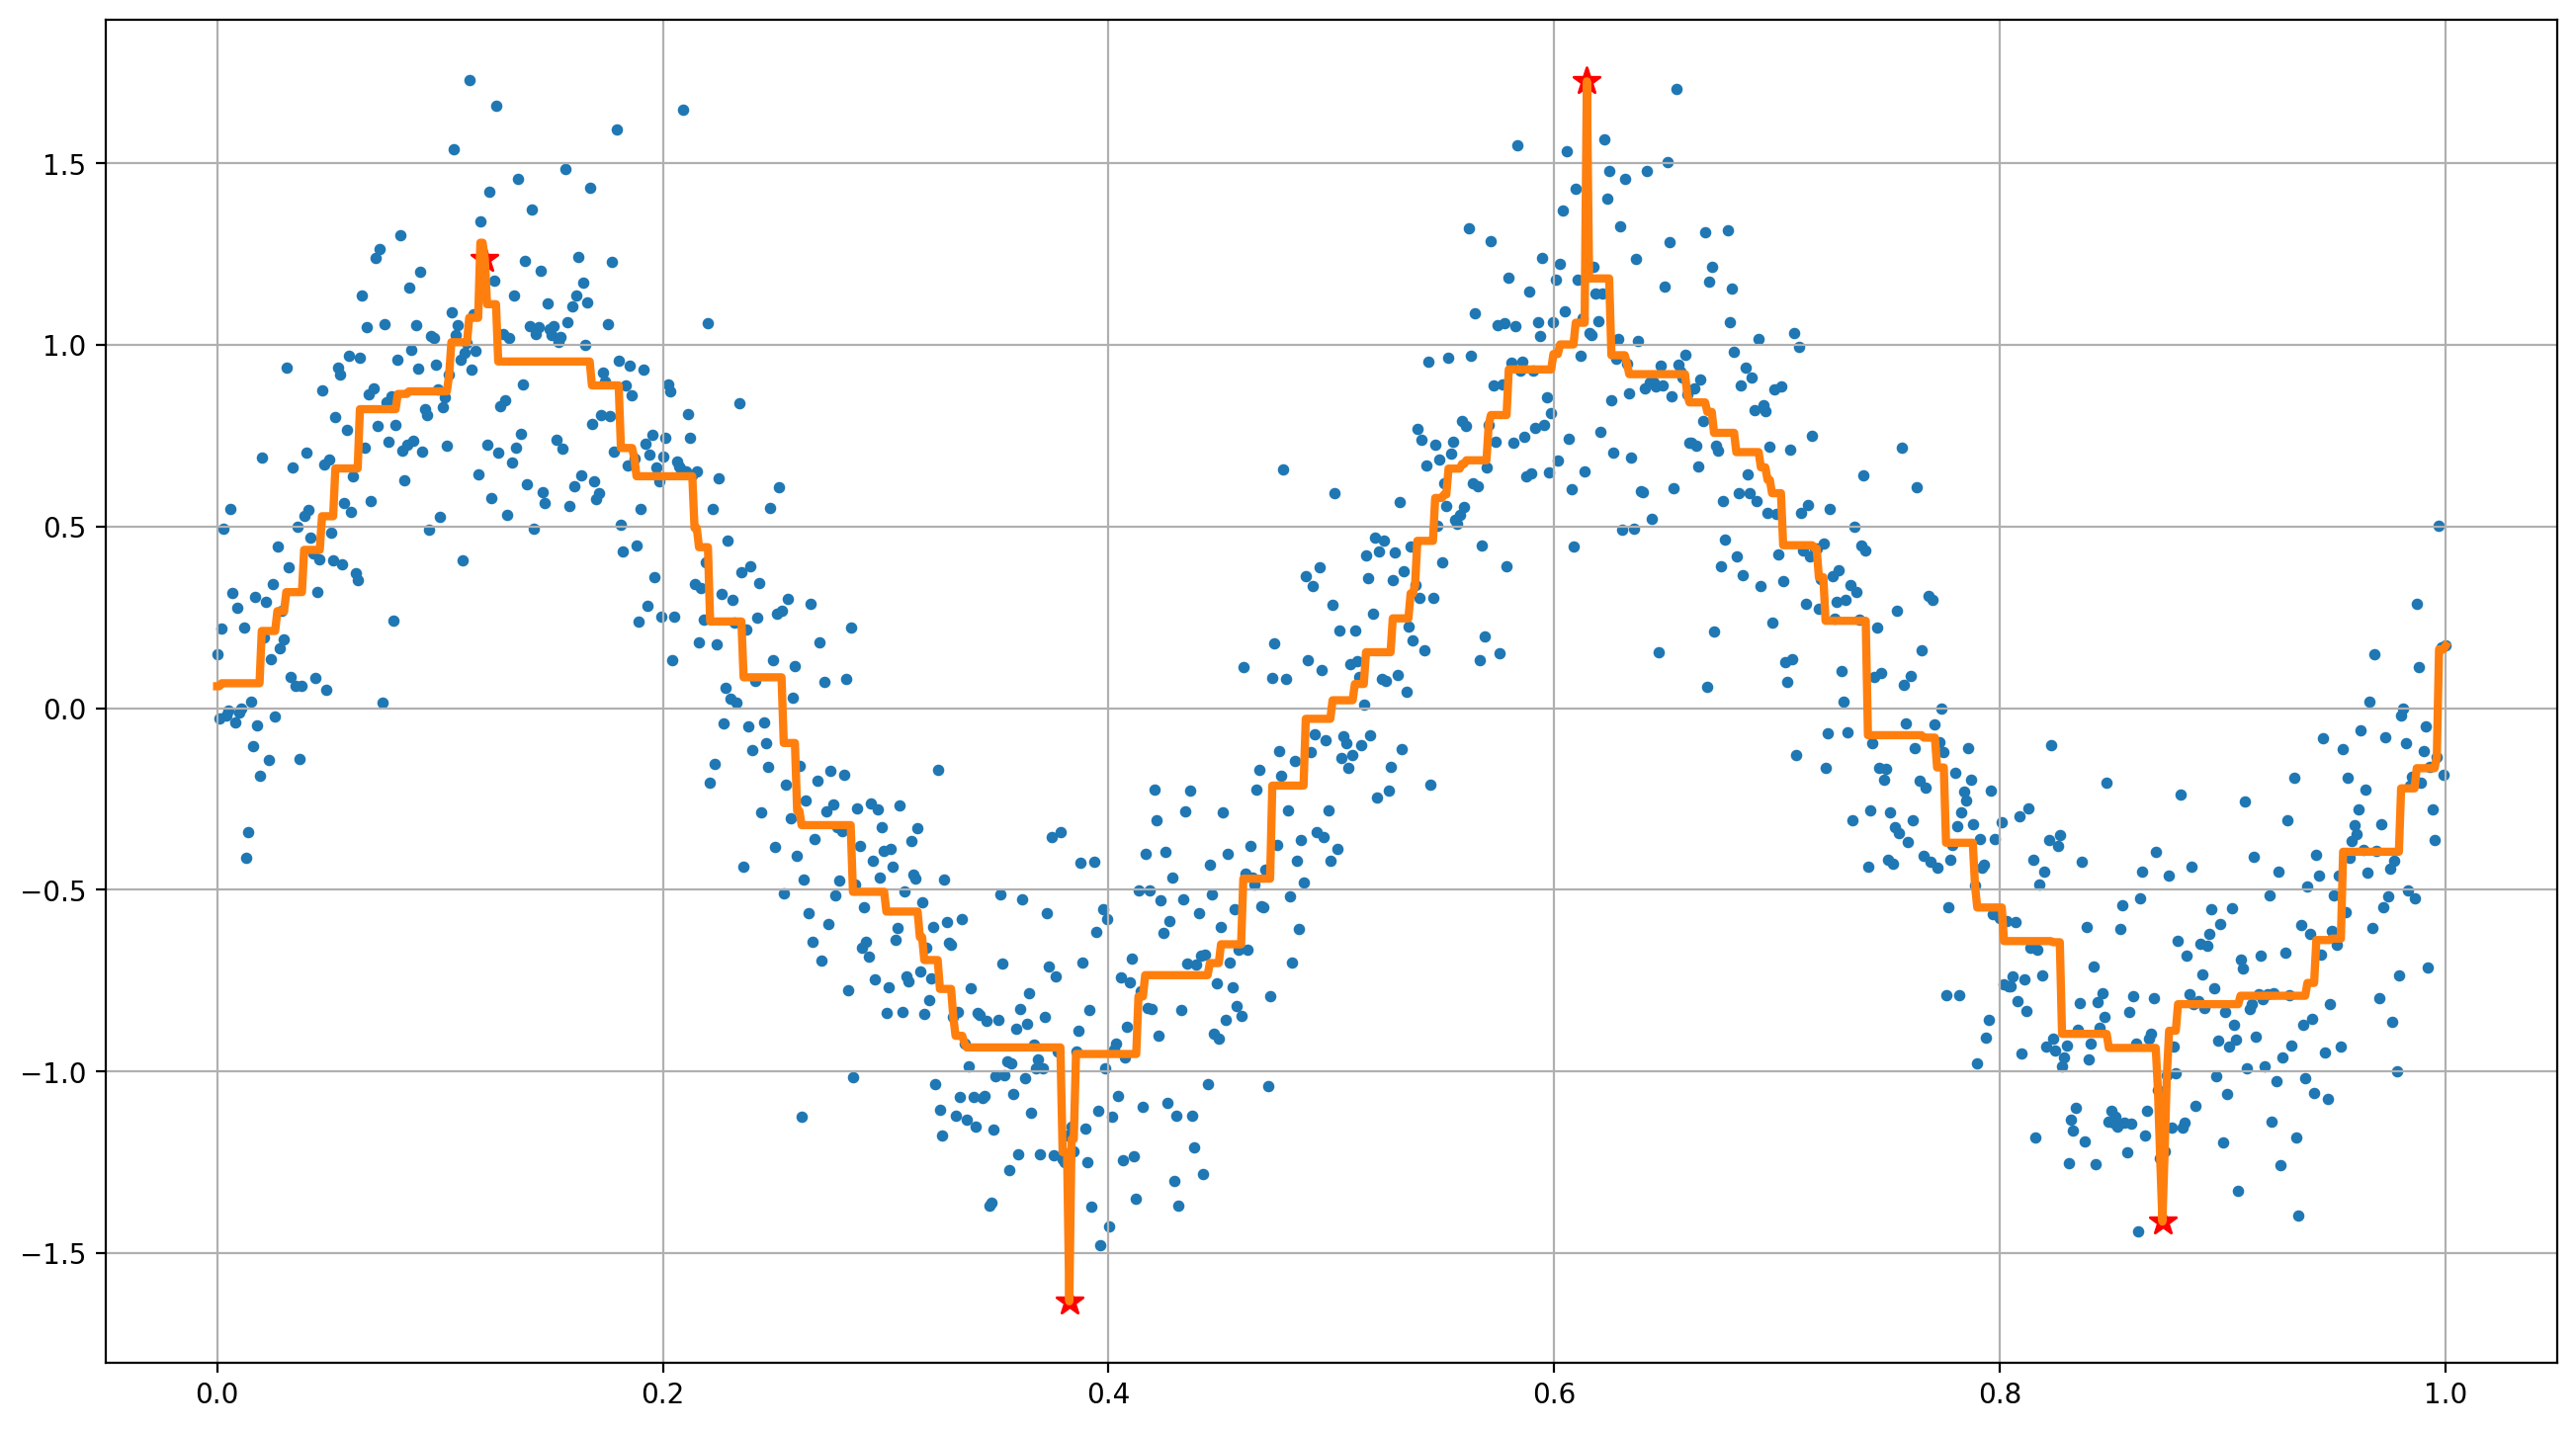

In [23]:
multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=new_pv_index)
multi_tuned_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg.isotonic_rss())
multi_tuned_pv_isoreg.plot_isoreg()

In [24]:
knots = get_knot(x, y)
knots

array([0.37838, 0.62863, 0.12112, 0.88088])

In [25]:
compre_csr1 = comprehensive_csr(x=x, y=y, pv_coordinate=new_pv[1:-1], pv_index=new_pv_index, knots_of_each_part=knots)
# compre_csr1 = comprehensive_csr(x=x, y=y, pv_coordinate=tmp_new_pv[1:-1], pv_index=tmp_new_pv_index, knots_of_each_part=knots)

In [26]:
# G, a, C, b = compre_csr1.generate_GaCb_matrix(deg=3)
# solve_qp(G, a, C, b, meq=4)[0]

In [27]:
# np.all(np.linalg.eigvals(G)>0)

In [28]:
y_constrained_result = compre_csr1.fit_constrained_transform(deg=3, meq=4, first_part_increase=True)

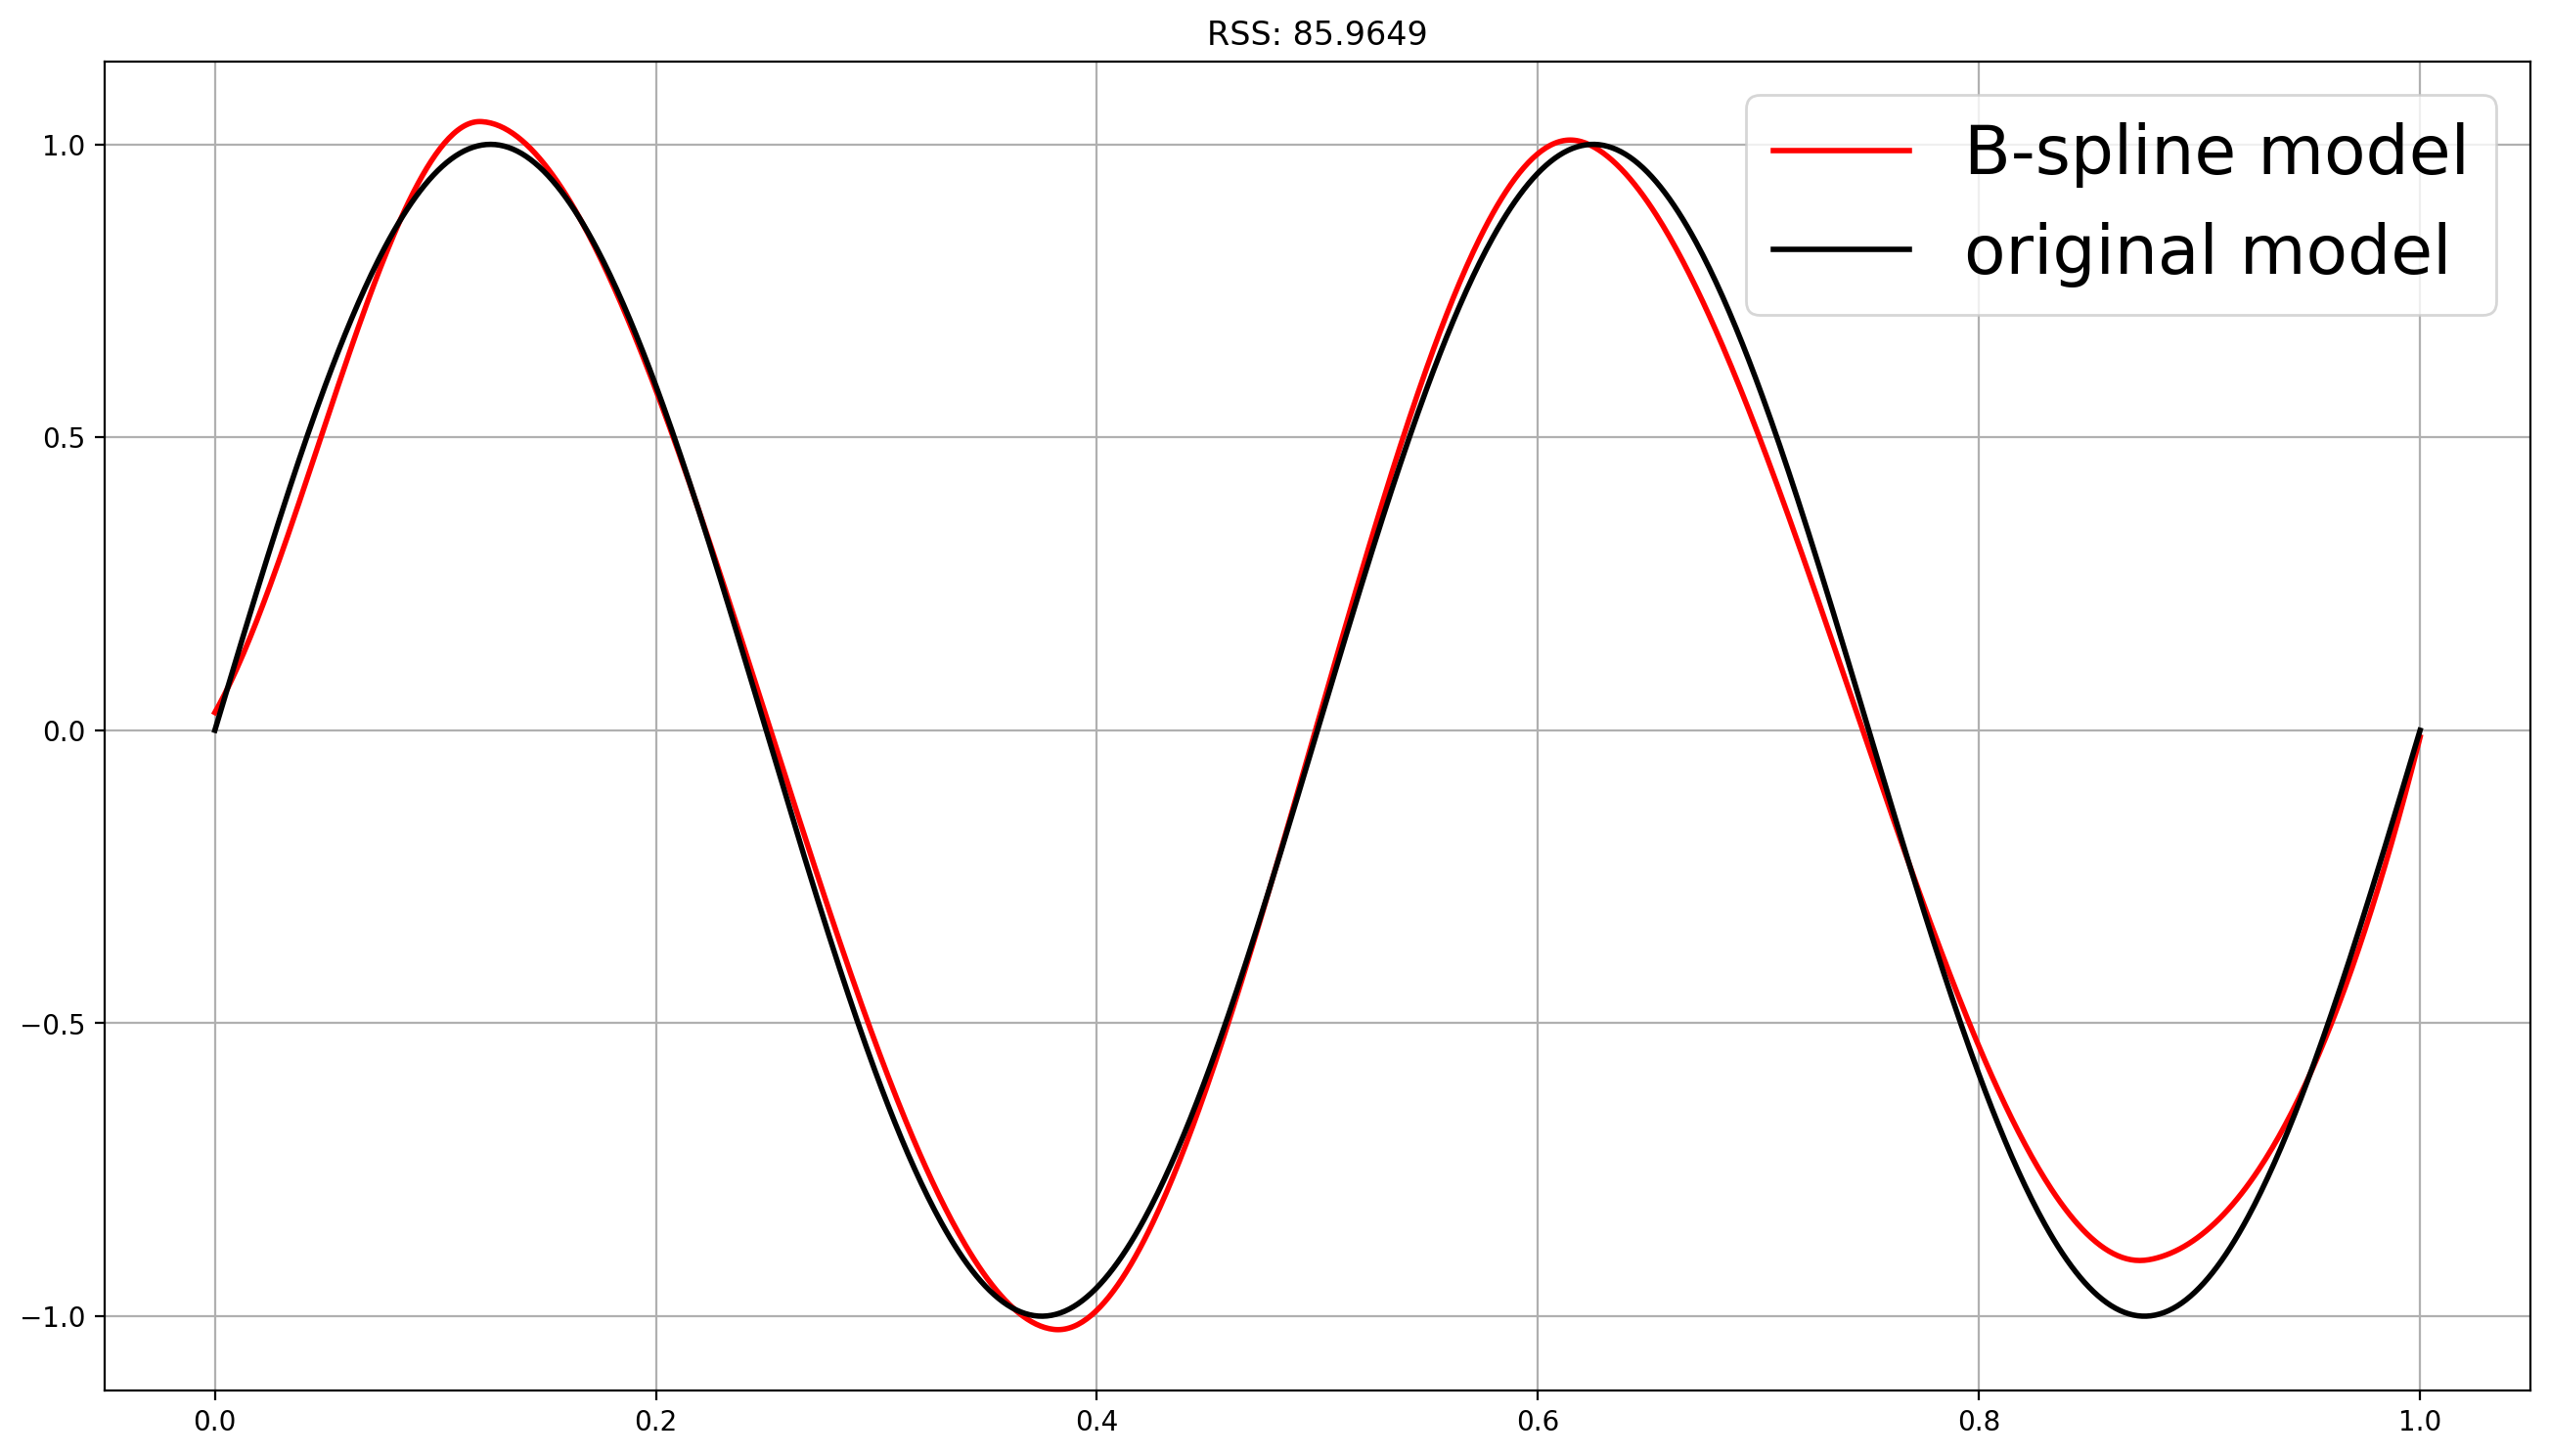

In [29]:
plt.figure(figsize=(16,9), dpi=200)
# plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result, c="r", label="B-spline model", linewidth=2)
plt.plot(x, f(x), c="k", label="original model", linewidth=2)
plt.legend(fontsize=25)
plt.title(f"RSS: {round(((y_constrained_result.reshape((-1,)) - y)**2).sum(), 4)}")
plt.grid()
plt.show()
# print("MSE: ", ((y_constrained_result.reshape((-1,)) - y)**2).mean())

In [30]:
print("RSS: ", ((y_constrained_result.reshape((-1,)) - f(x))**2).mean())

RSS:  0.0020806904010523034


In [31]:
coef1 = compre_csr1.Solve_QP(deg=3, meq=4)
print("coef: ", coef1)
knots1 = compre_csr1.comprehensive_knots()
print("knots1: ", knots1)

coef:  [ 0.03030415  0.29493301  1.04507104  1.0255619  -0.98363548 -1.05794846
  1.12990747  0.87102391 -0.96003912 -0.8762855  -0.60247307 -0.01156381]
knots1:  [0.12012, 0.12112, 0.37838, 0.38238, 0.61461, 0.62863, 0.87287, 0.88088]


In [32]:
def fhat1(w):
    bx = patsy.bs(x=w, knots=knots1, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef1
    return ans
def SE1(w):
    return (fhat1(w) - f(w))**2

In [33]:
ise1, _ = quad(SE1, 0, 1)
print("ISE: ", round(ise1, 8))

ISE:  0.00208222


### 使用 [Scipy Peak finding](https://scipy.github.io/devdocs/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks) 方法找峰谷位置

In [34]:
peaks, _ = find_peaks(y, distance=200, prominence=1, height=1)
valleys, _ = find_peaks(-y, distance=200, prominence=1, height=1)
pv_index2 = np.hstack((peaks, valleys))
pv_index2.sort()

In [35]:
pv2 = x[pv_index2]
print(pv2)

[0.11311 0.38238 0.61461 0.86186]


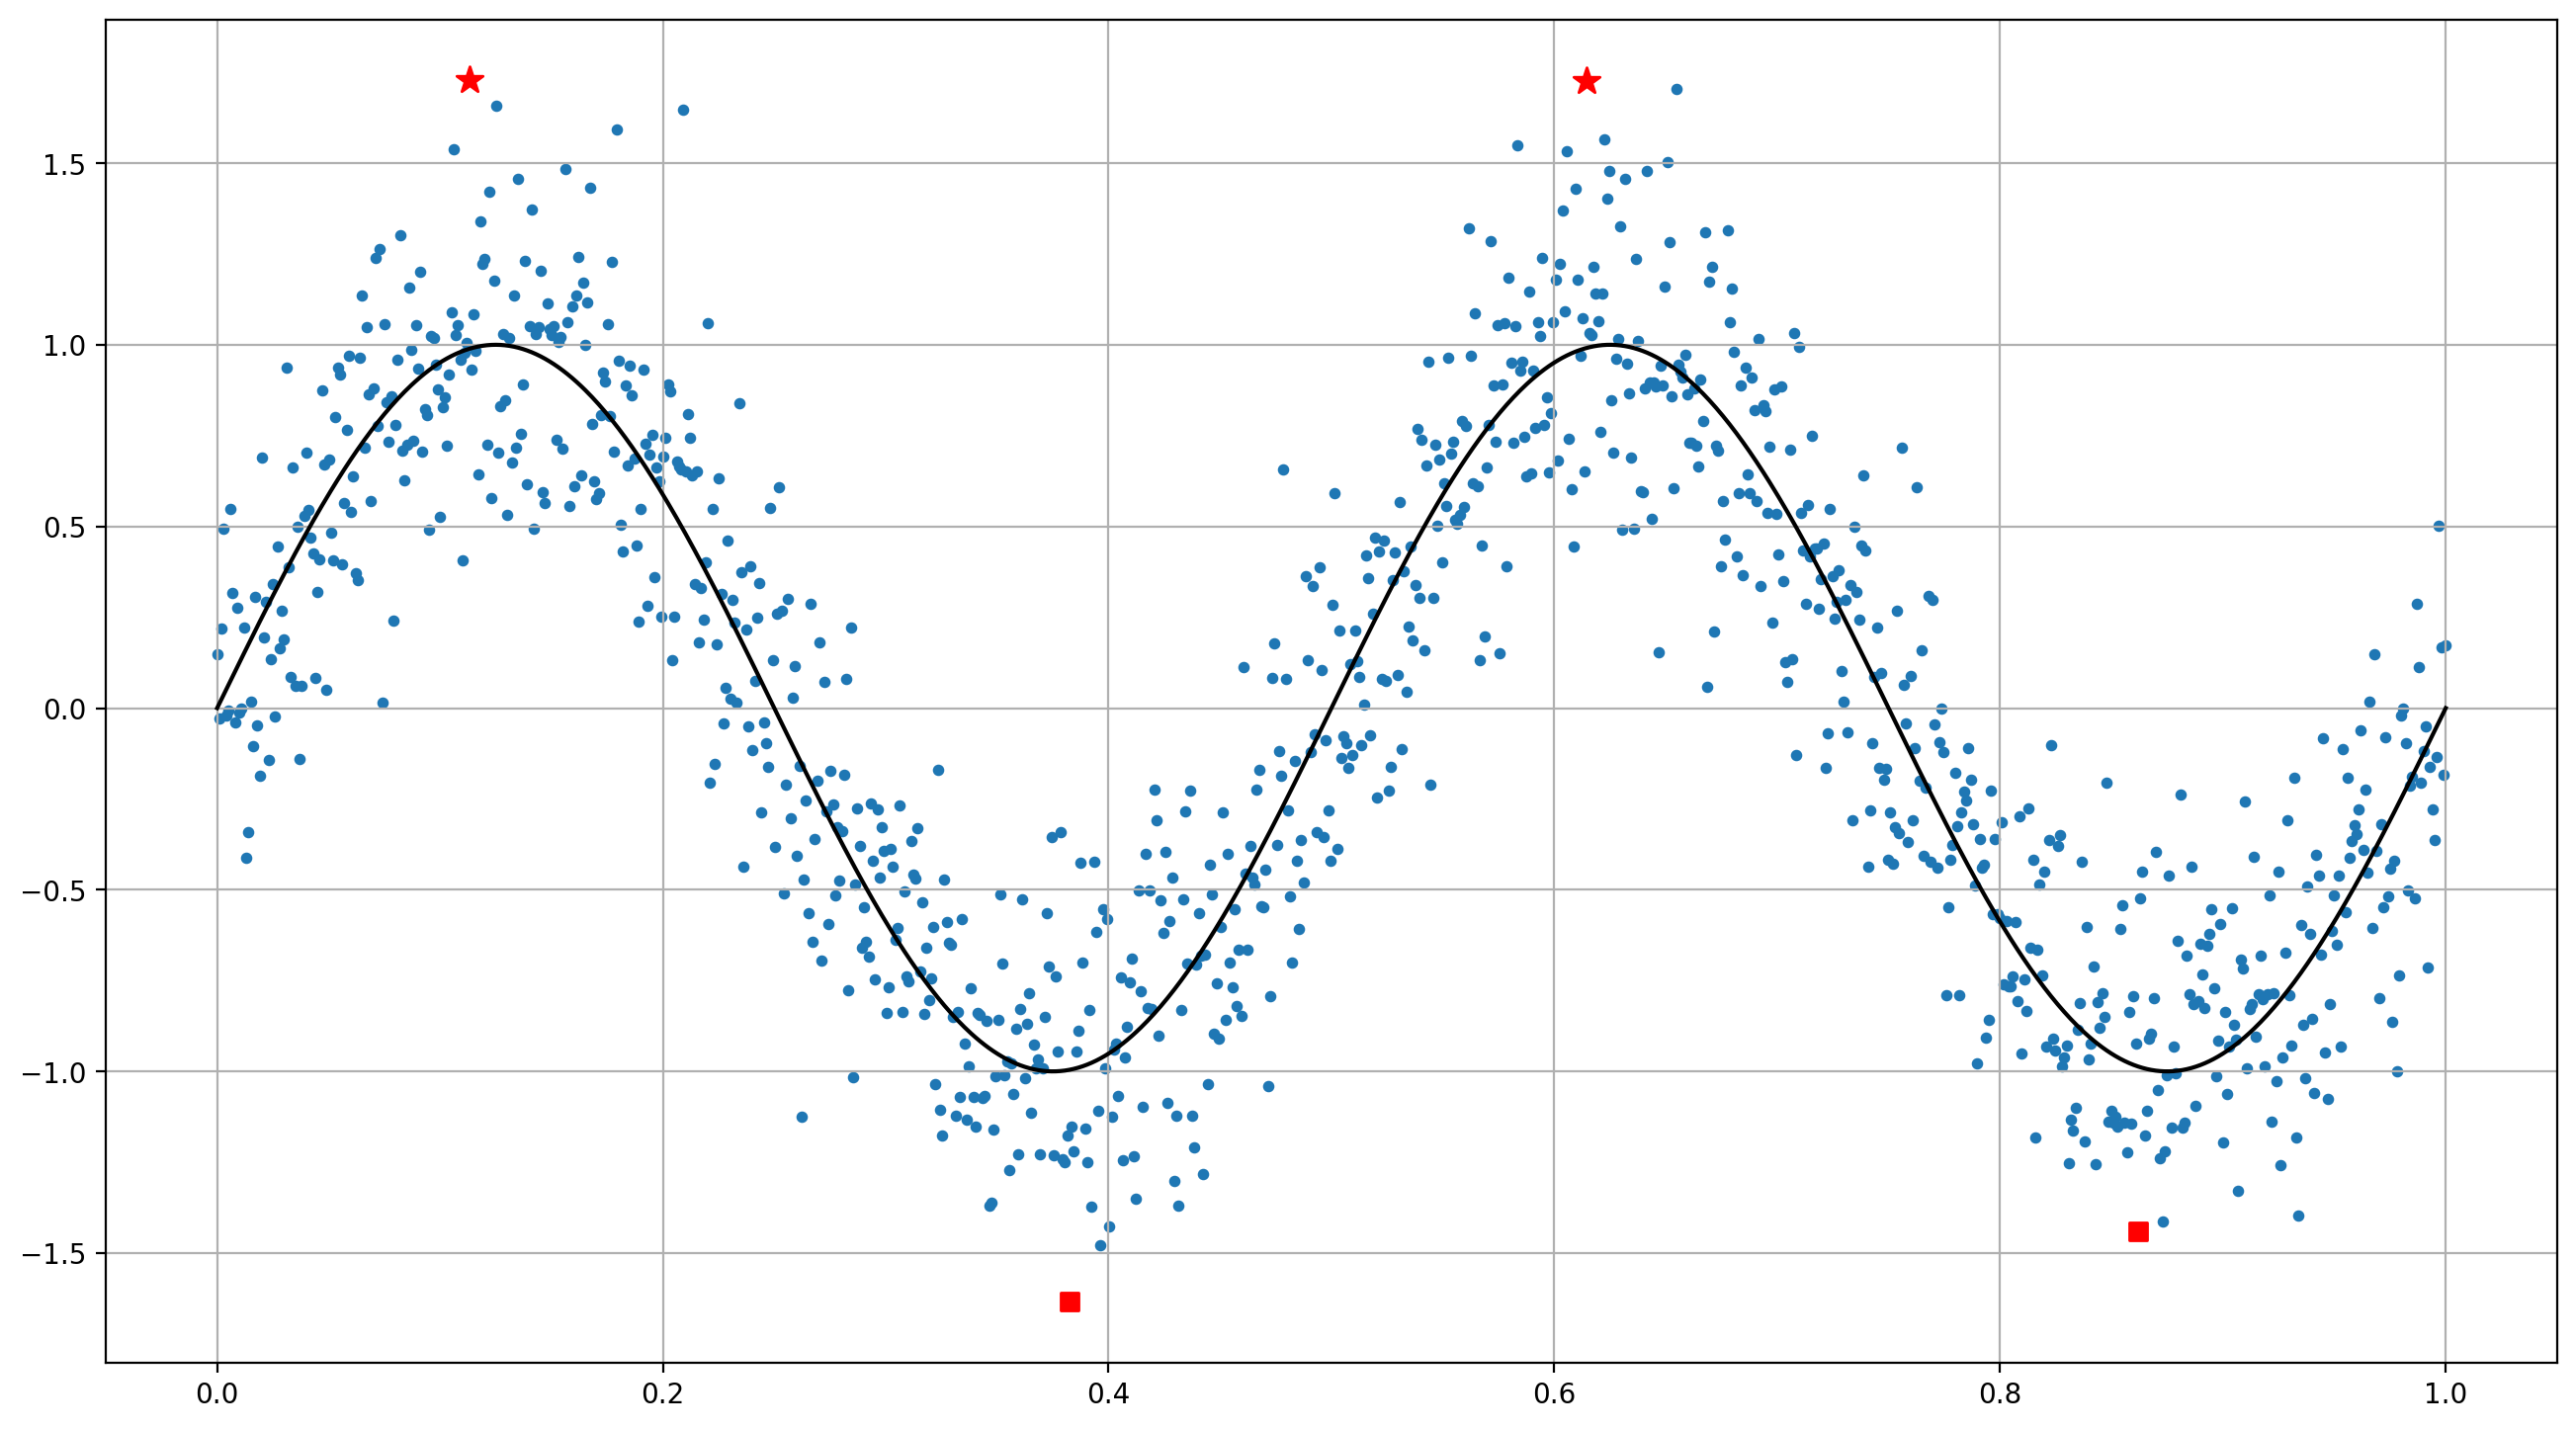

In [36]:
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[peaks], y[peaks], s=100, c="r", marker='*')
plt.scatter(x[valleys], y[valleys], s=45, c="r", marker='s')
plt.grid()
plt.show()

RSS:  71.32948130157484


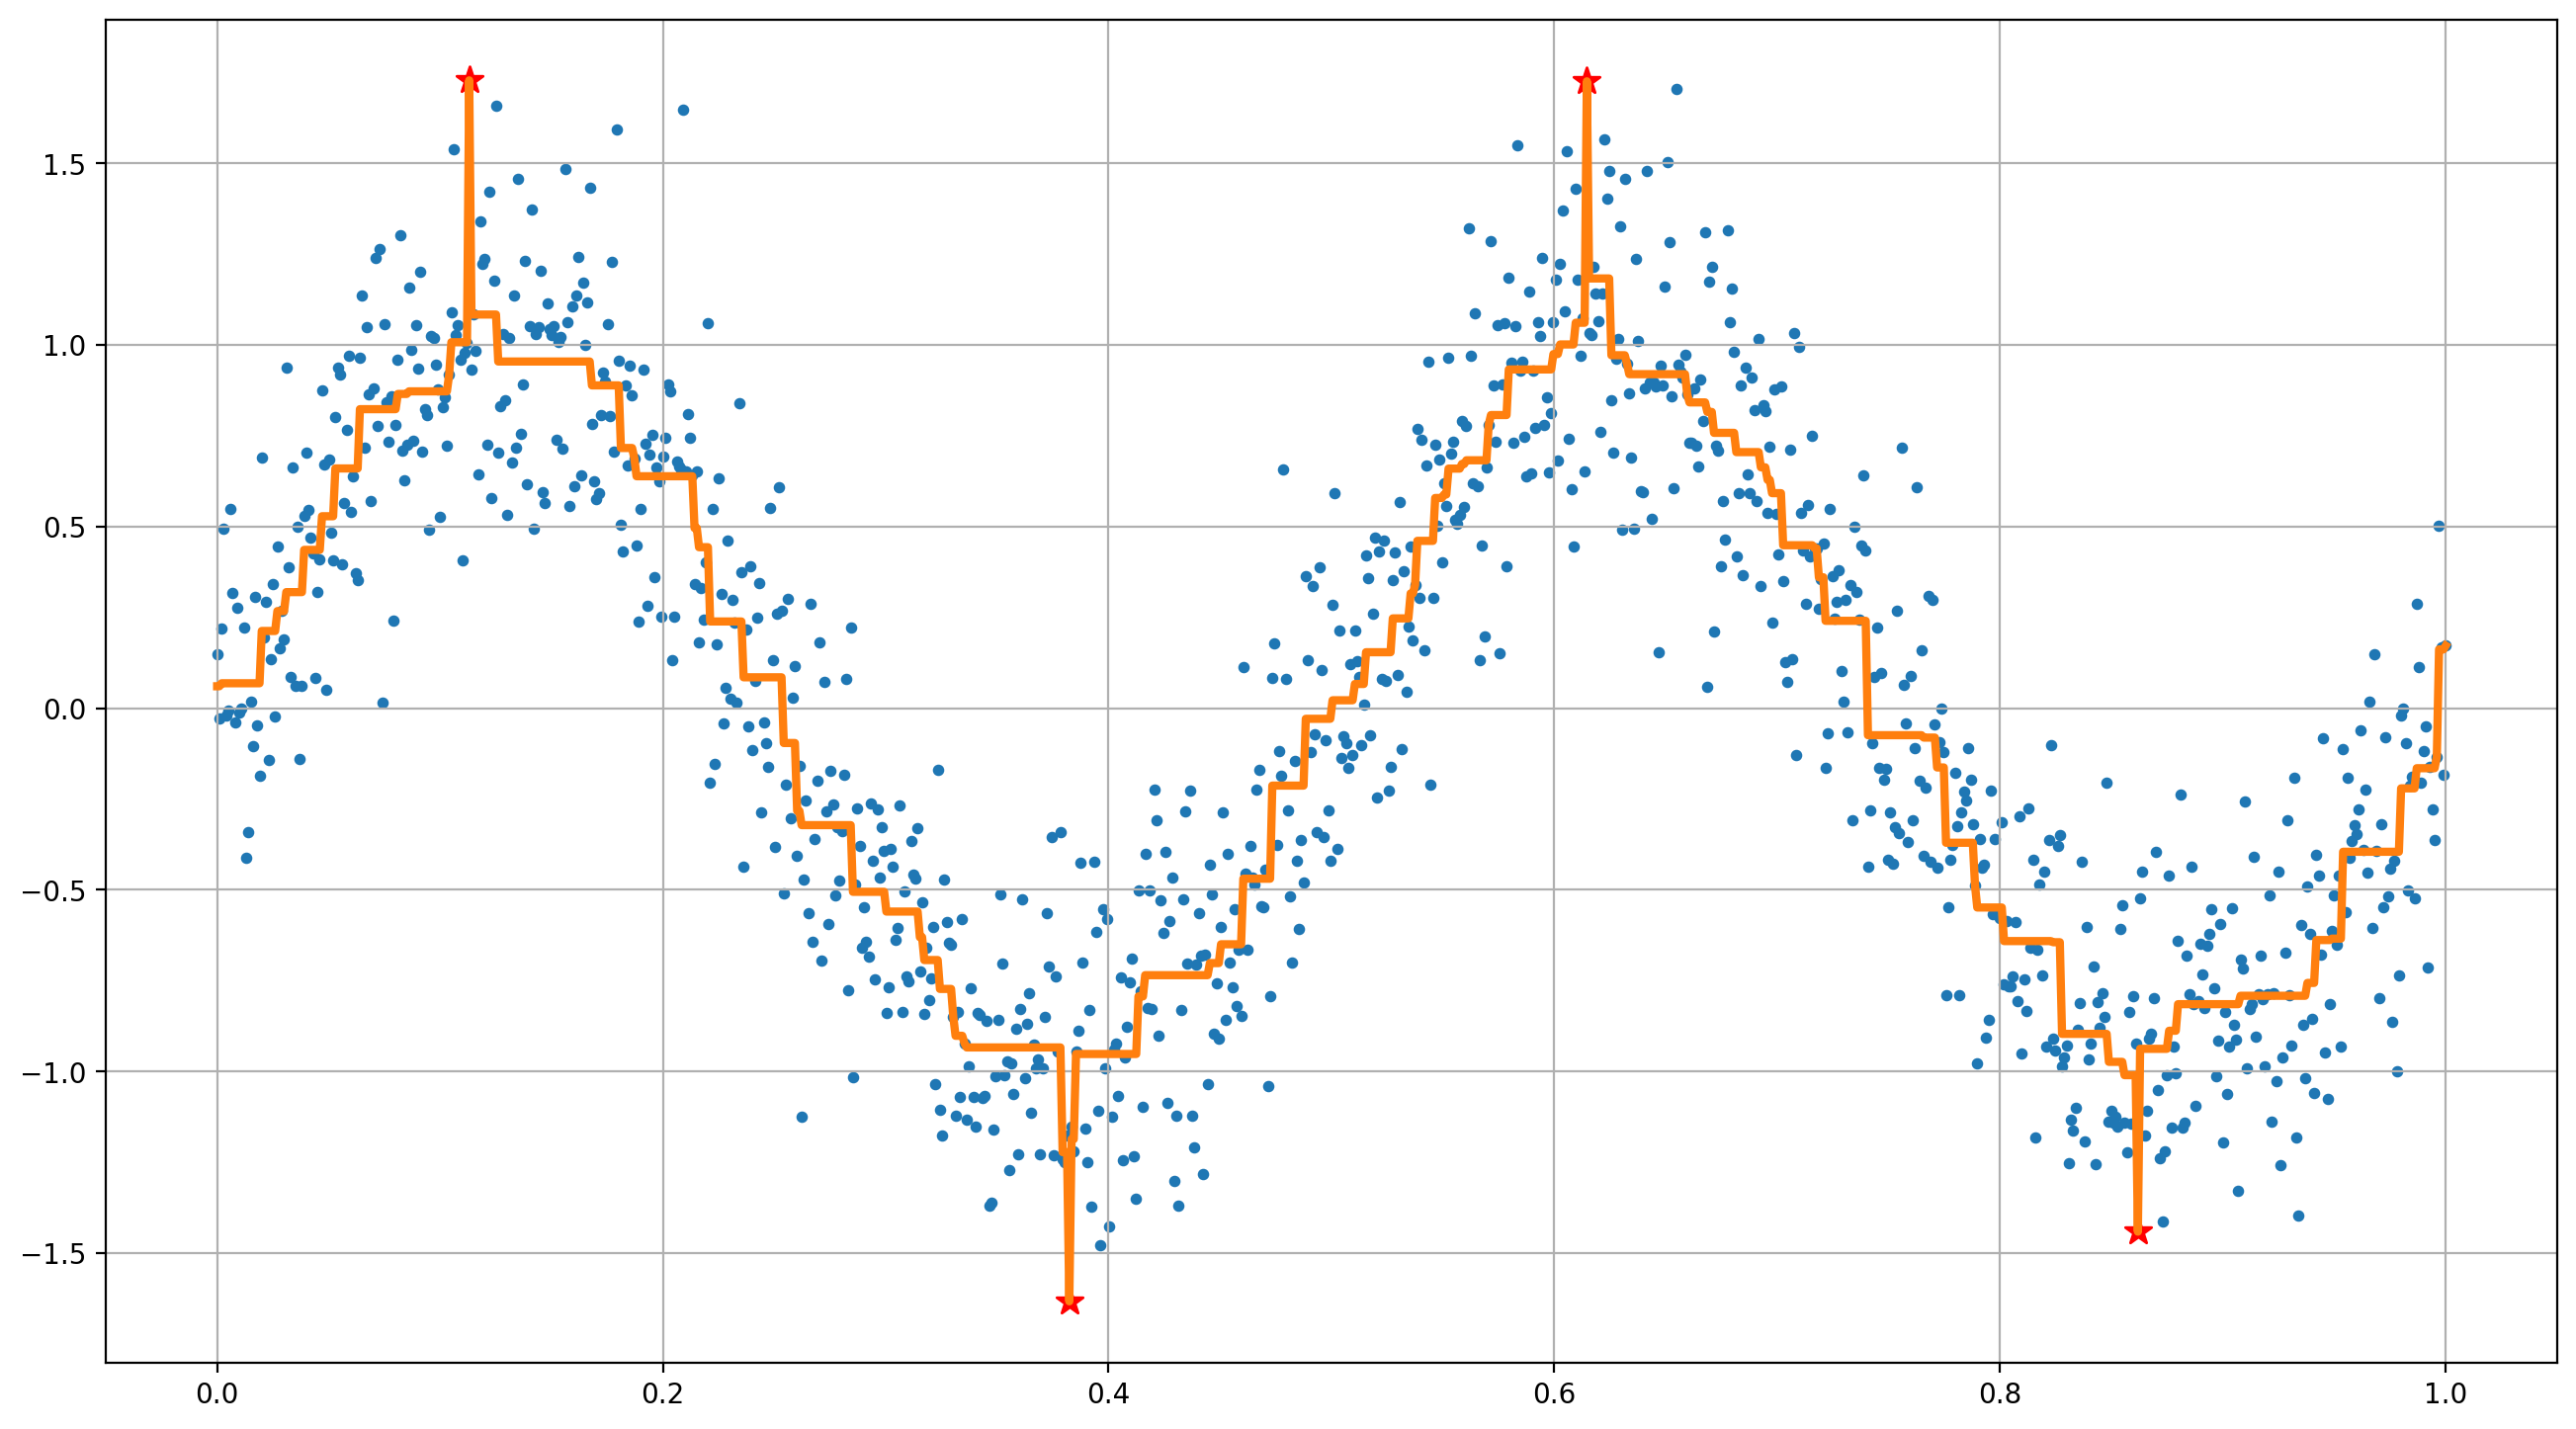

In [37]:
multi_tuned_pv_isoreg2 = IsotonicReg(x=x, y=y, pv_index=[0]+list(pv_index2)+[999])
multi_tuned_pv_isoreg2.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg2.isotonic_rss())
multi_tuned_pv_isoreg2.plot_isoreg()

In [38]:
compre_csr2 = comprehensive_csr(x=x, y=y, pv_coordinate=pv2, pv_index=pv_index2, knots_of_each_part=knots)

In [39]:
y_constrained_result2 = compre_csr2.fit_constrained_transform(deg=3, meq=4, first_part_increase=True)

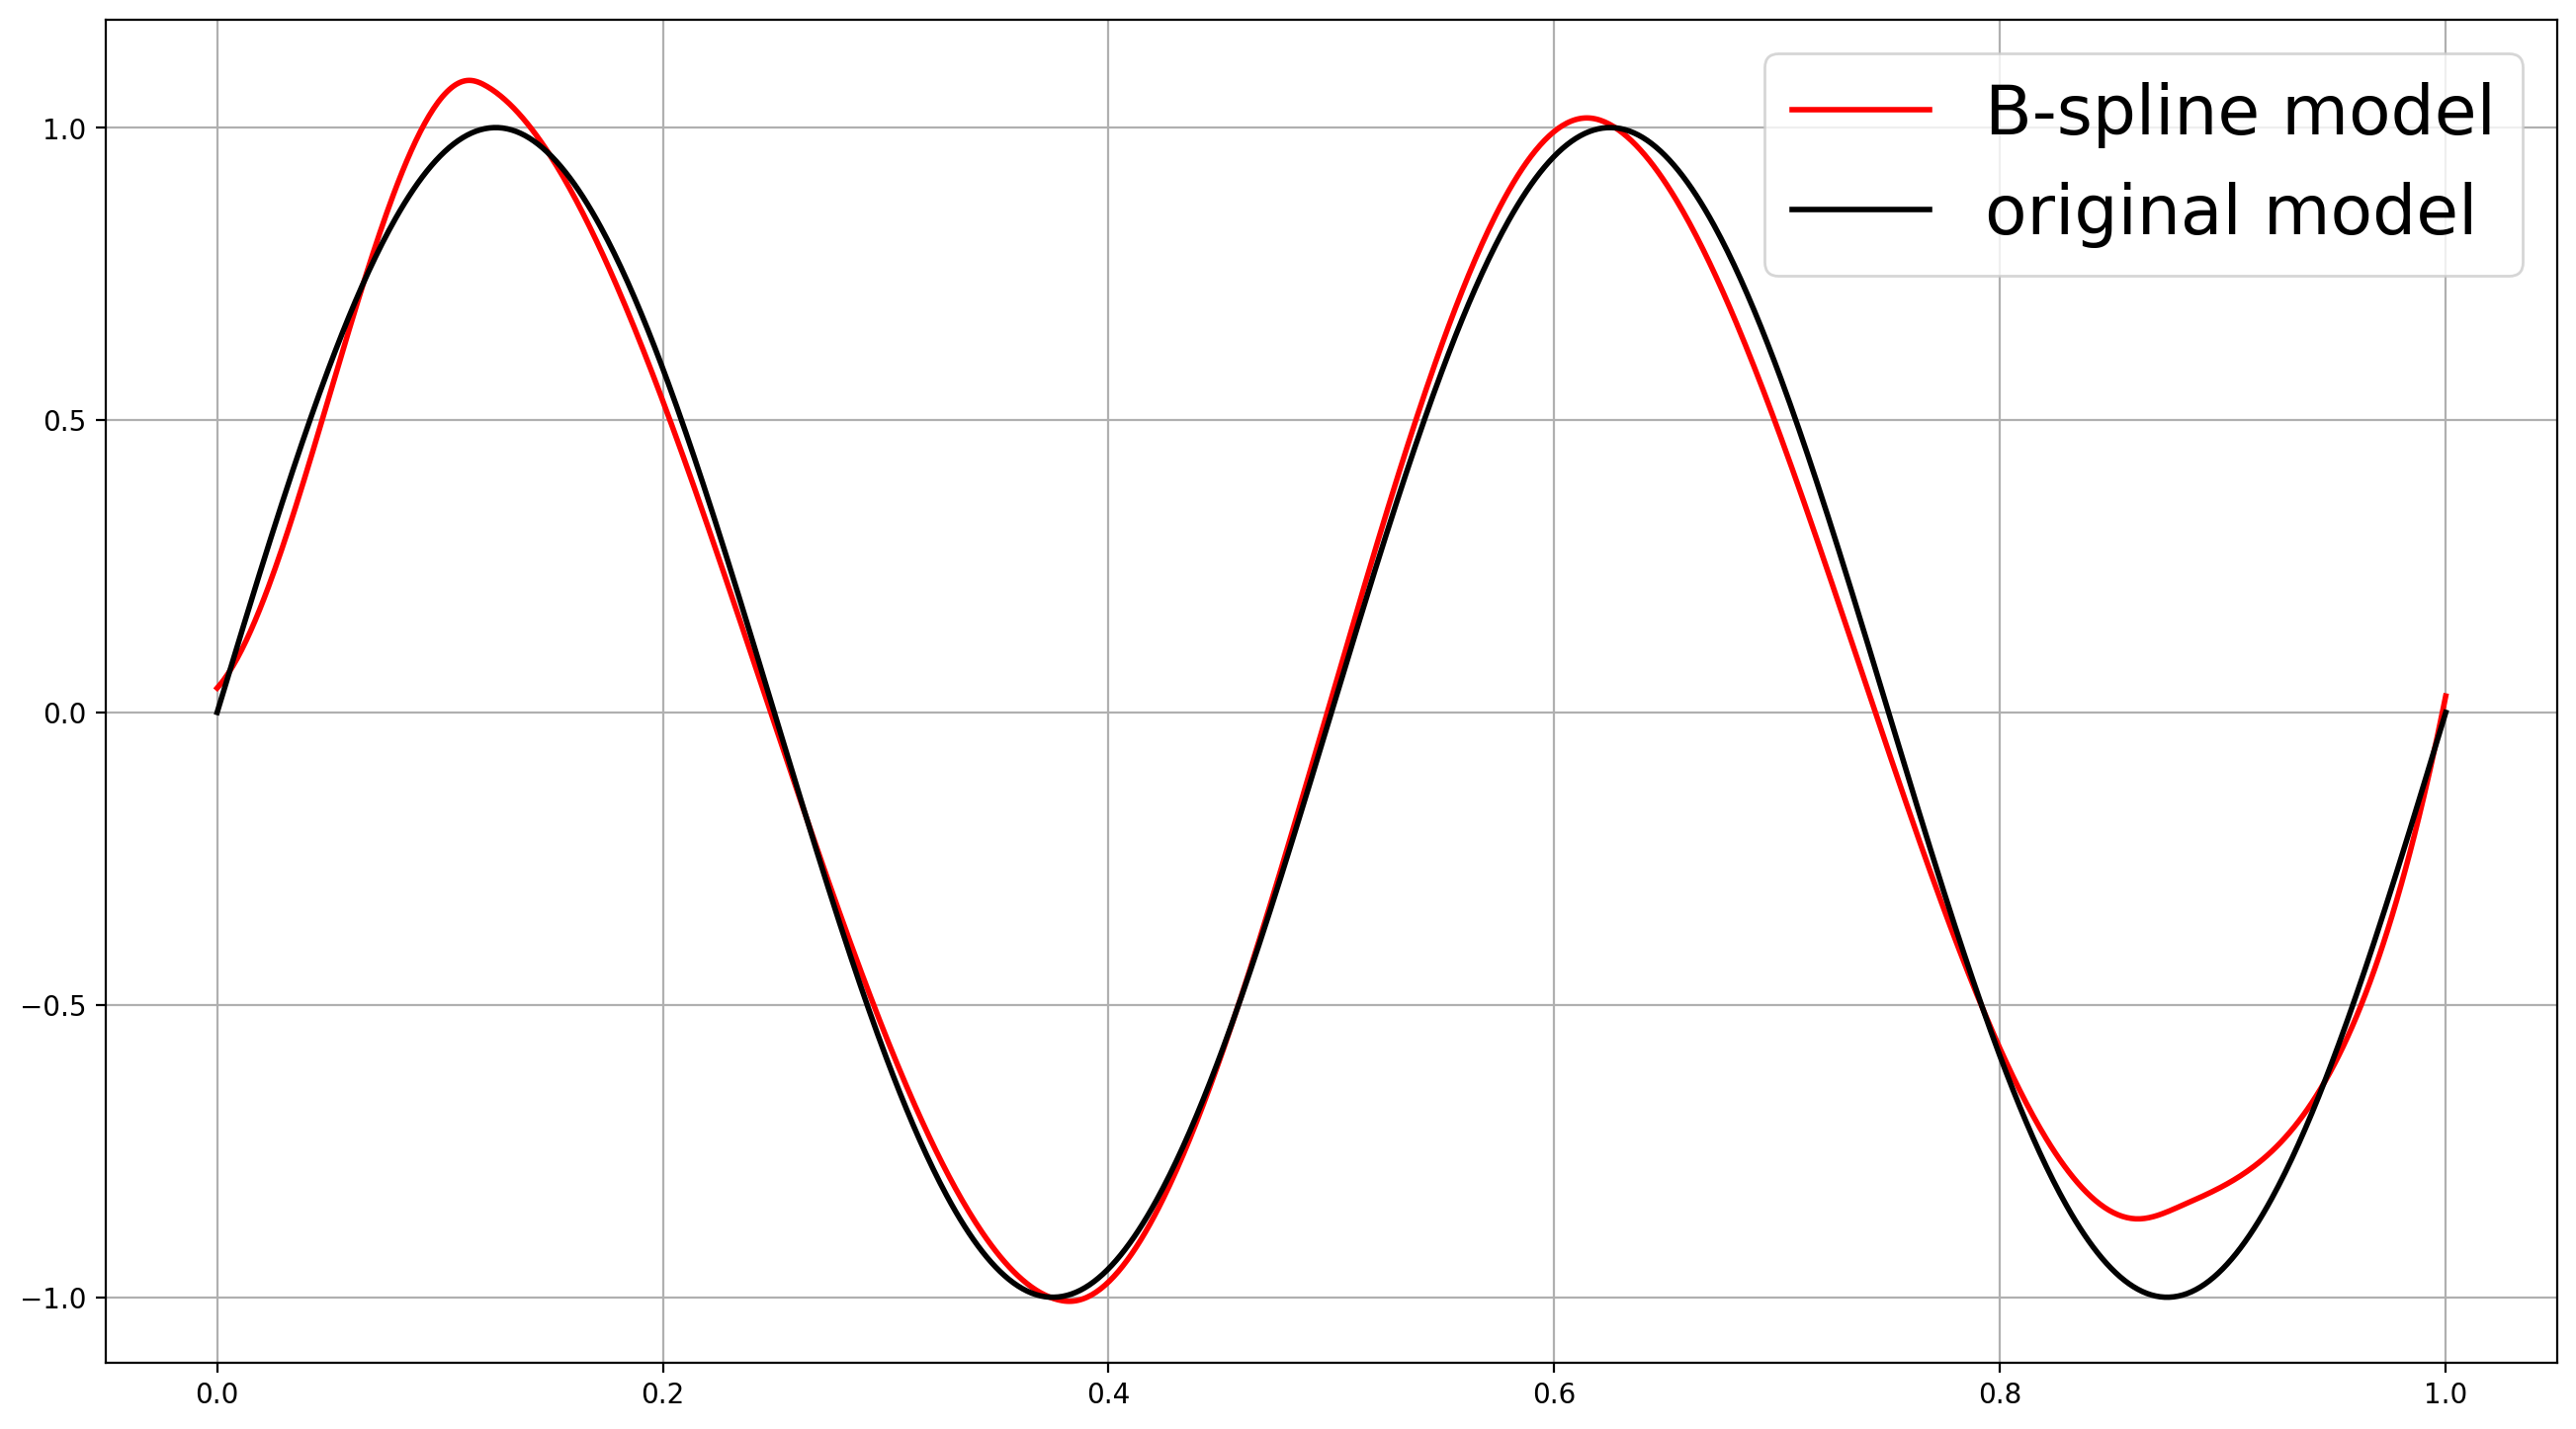

MSE:  0.08698628964017613


In [40]:
plt.figure(figsize=(16,9), dpi=200)
# plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result2, c="r", label="B-spline model", linewidth=2)
plt.plot(x, f(x), c="k", label="original model", linewidth=2)
plt.legend(fontsize=25)
plt.grid()
plt.show()
print("MSE: ", ((y_constrained_result2.reshape((-1,)) - y)**2).mean())

In [41]:
print("RSS: ", ((y_constrained_result2.reshape((-1,)) - f(x))**2).mean())

RSS:  0.0034249758364429356


In [42]:
coef2 = compre_csr2.Solve_QP(deg=3, meq=4)
print("coef: ", coef2)
knots2 = compre_csr2.comprehensive_knots()
print("knots2: ", knots2)

coef:  [ 0.04168862  0.20031392  1.14307446  0.93450764 -0.96773238 -1.04179318
  1.13863832  0.8864247  -1.00081664 -0.78616307 -0.72236563  0.02805928]
knots2:  [0.11311, 0.12112, 0.37838, 0.38238, 0.61461, 0.62863, 0.86186, 0.88088]


In [43]:
def fhat2(w):
    bx = patsy.bs(x=w, knots=knots2, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef2
    return ans
def SE2(w):
    return (fhat2(w) - f(w))**2

In [44]:
ise2, _ = quad(SE2, 0, 1)
print("ISE: ", ise2)

ISE:  0.00342704597577276


### 使用 [findpeaks Peakdetect](https://erdogant.github.io/findpeaks/pages/html/Peakdetect.html) 方法找峰谷位置

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


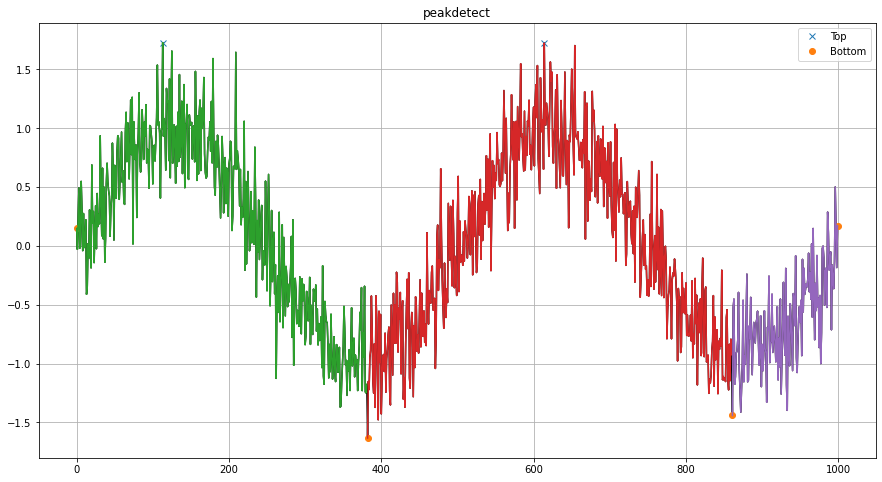

(None, <AxesSubplot:title={'center':'peakdetect'}>)

In [45]:
fp = findpeaks(method="peakdetect", lookahead=100)
fp_result = fp.fit(y)
fp.plot()

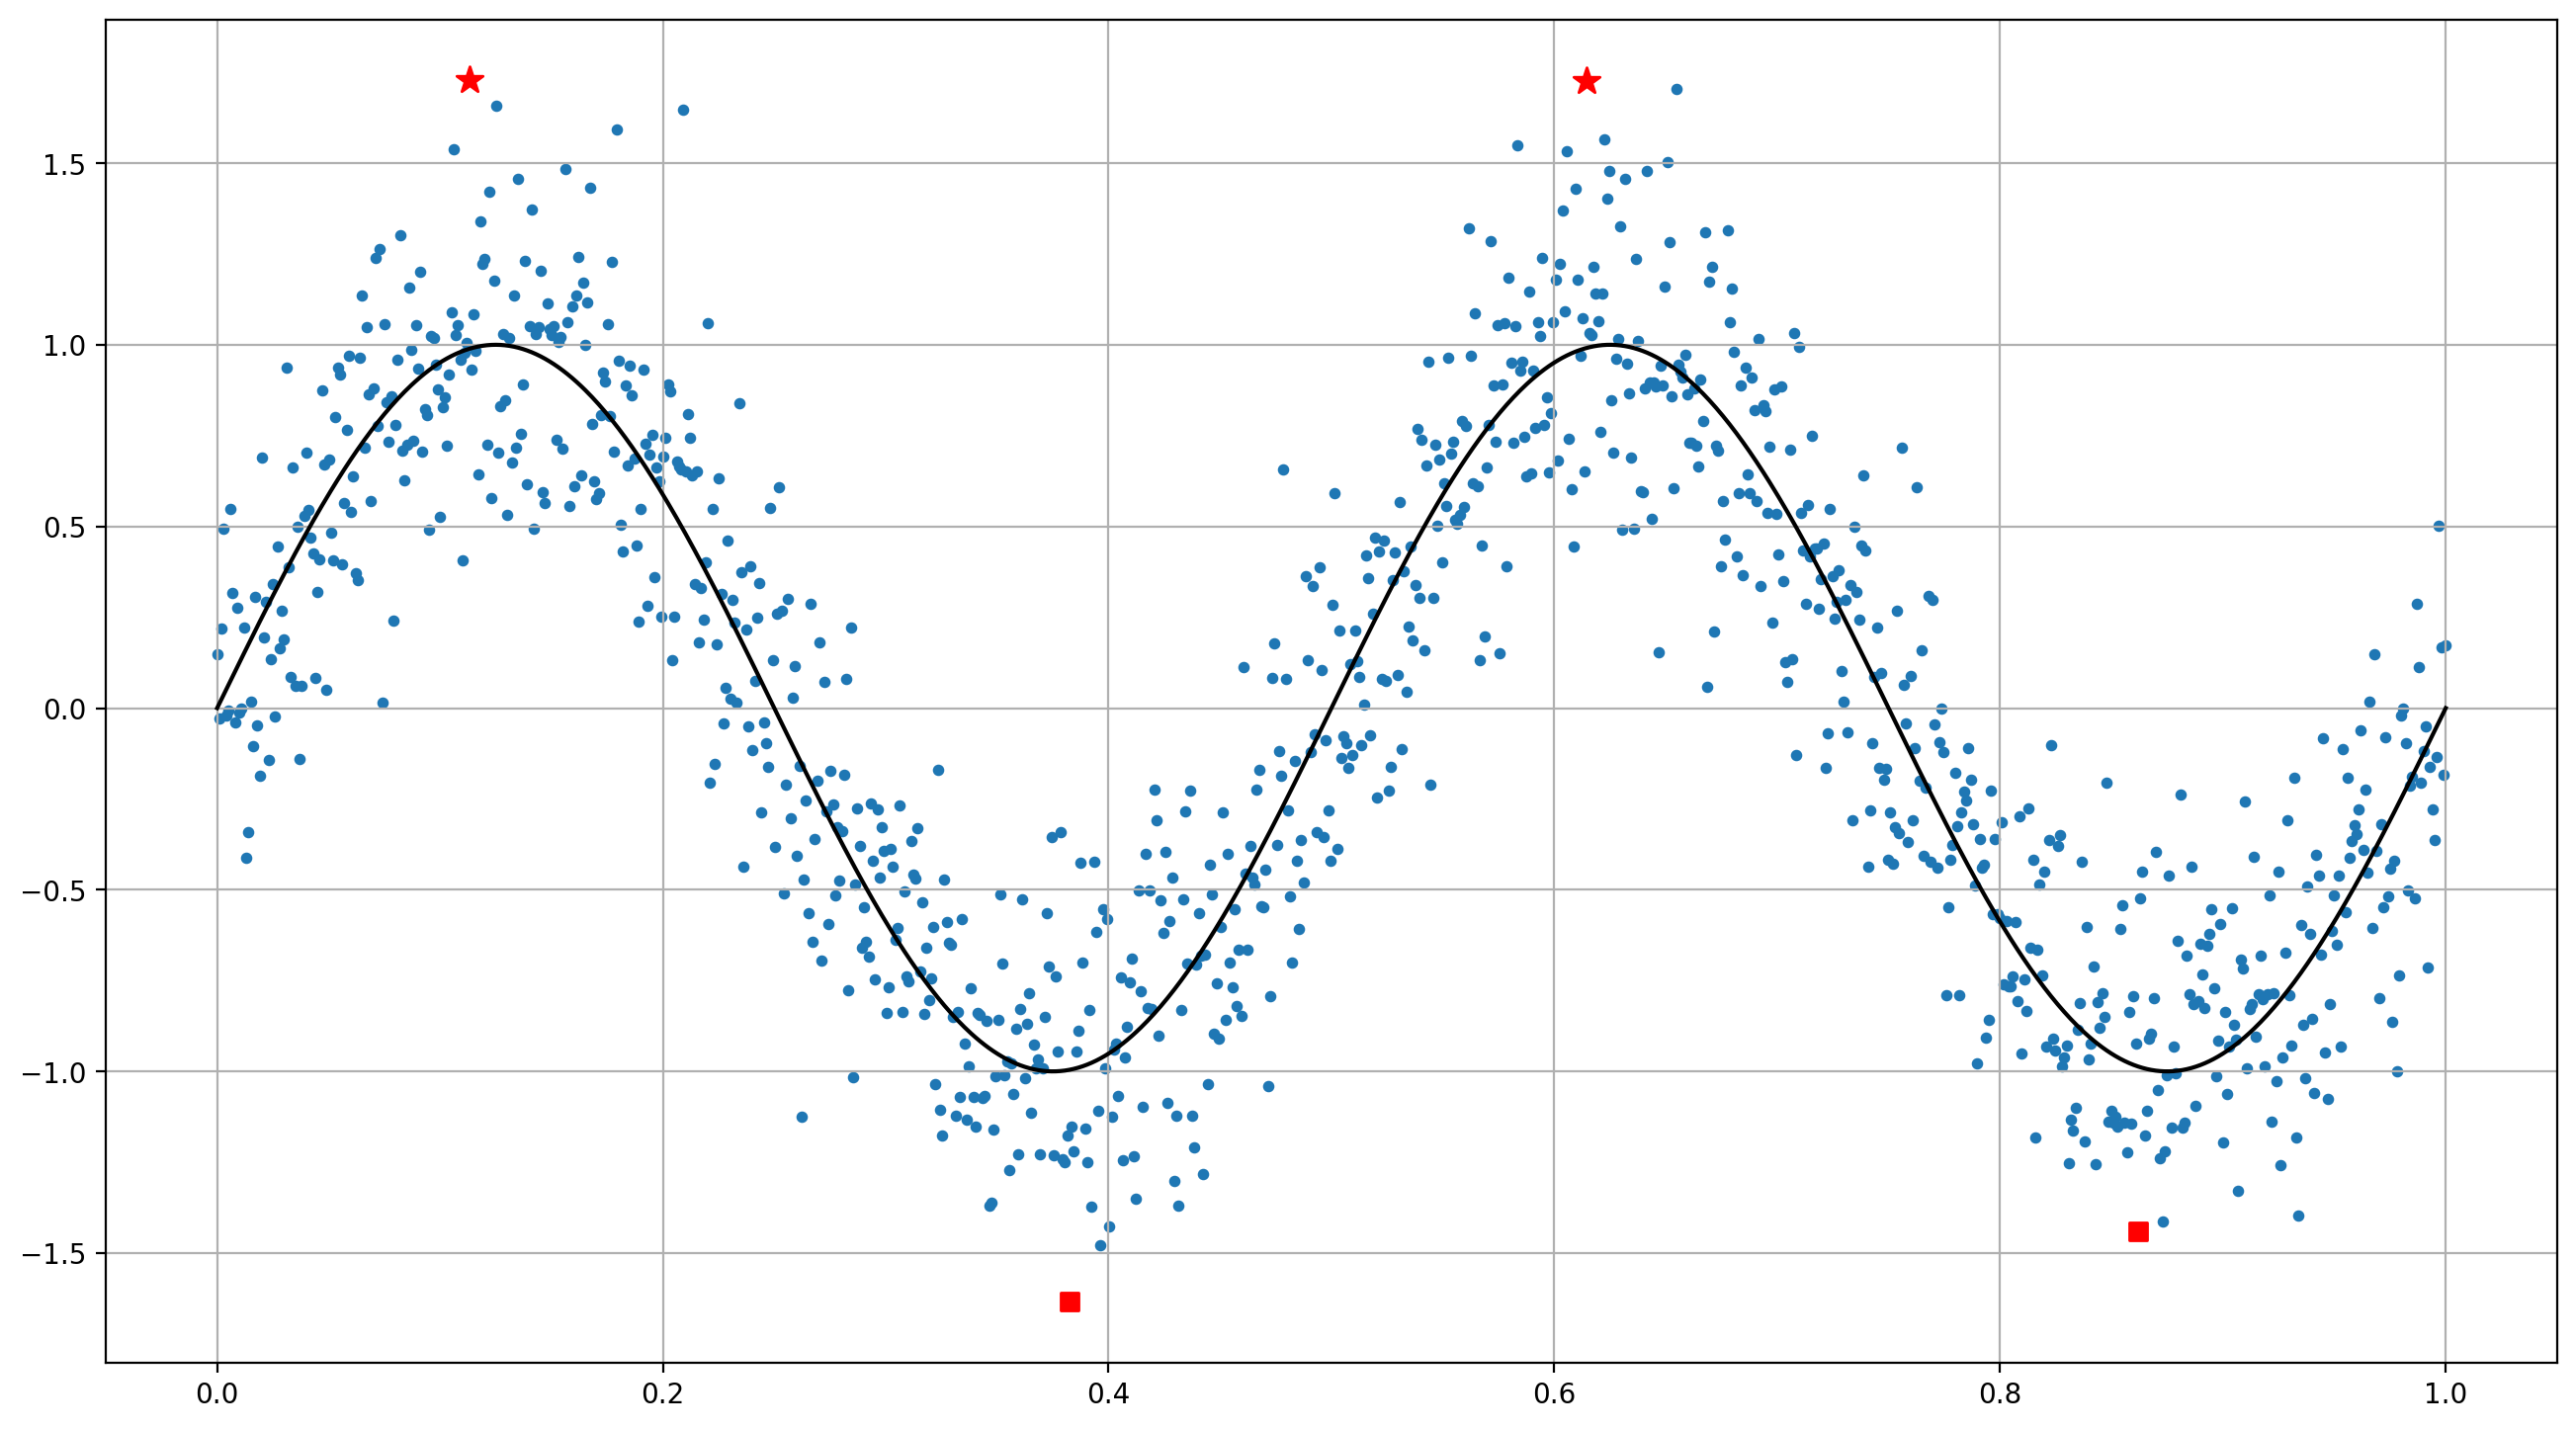

In [46]:
plt.figure(figsize=(16,9), dpi=200)
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[fp_result["df"]["peak"]], y[fp_result["df"]["peak"]], s=100, c="r", marker='*')
plt.scatter(x[fp_result["df"]["valley"]][1:-1], y[fp_result["df"]["valley"]][1:-1], s=45, c="r", marker='s')
plt.grid()
plt.show()

In [47]:
pv_index3 = (fp_result["df"]["peak"]|fp_result["df"]["valley"]).to_numpy()
pv3 = x[pv_index3]
print(pv3)

[0.      0.11311 0.38238 0.61461 0.86186 1.     ]


RSS:  71.32948130157484


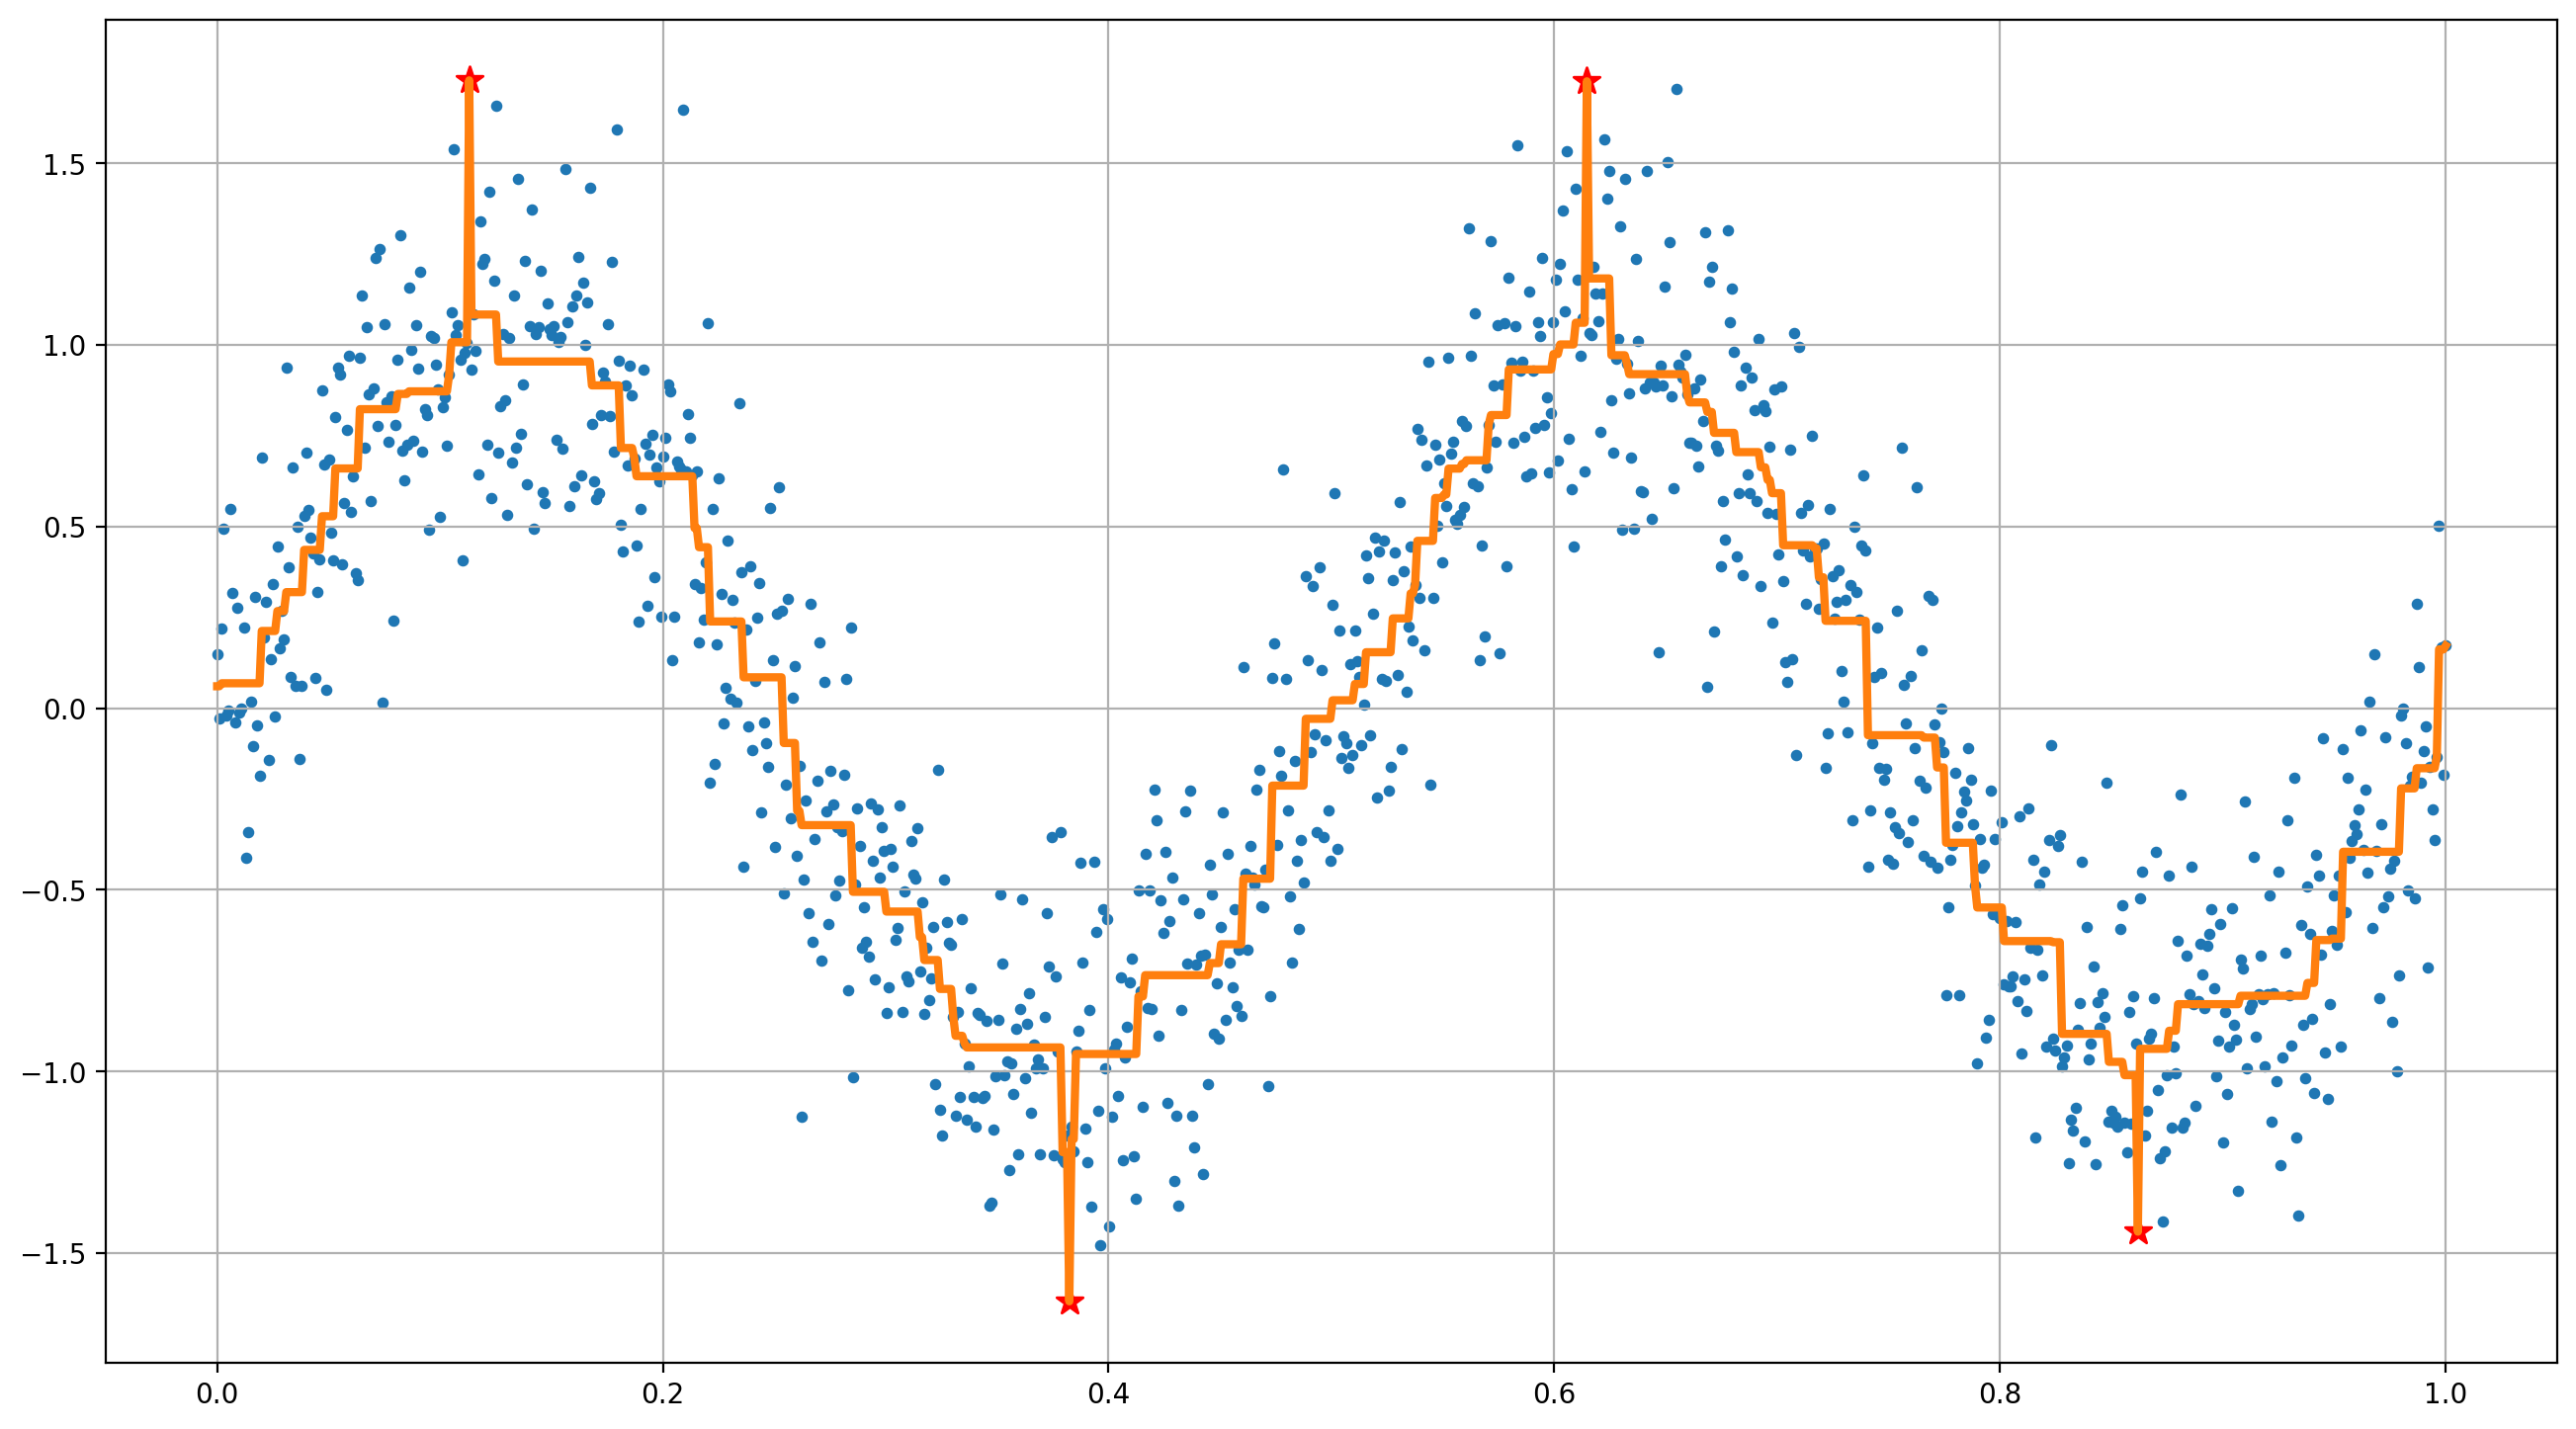

In [48]:
multi_tuned_pv_isoreg3 = IsotonicReg(x=x, y=y, pv_index=np.where(pv_index3==True)[0])
multi_tuned_pv_isoreg3.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg3.isotonic_rss())
multi_tuned_pv_isoreg3.plot_isoreg()

In [49]:
compre_csr3 = comprehensive_csr(x=x, y=y, pv_coordinate=pv3[1:-1], pv_index=pv_index3, knots_of_each_part=knots)

In [50]:
y_constrained_result3 = compre_csr3.fit_constrained_transform(deg=3, meq=3, first_part_increase=True)

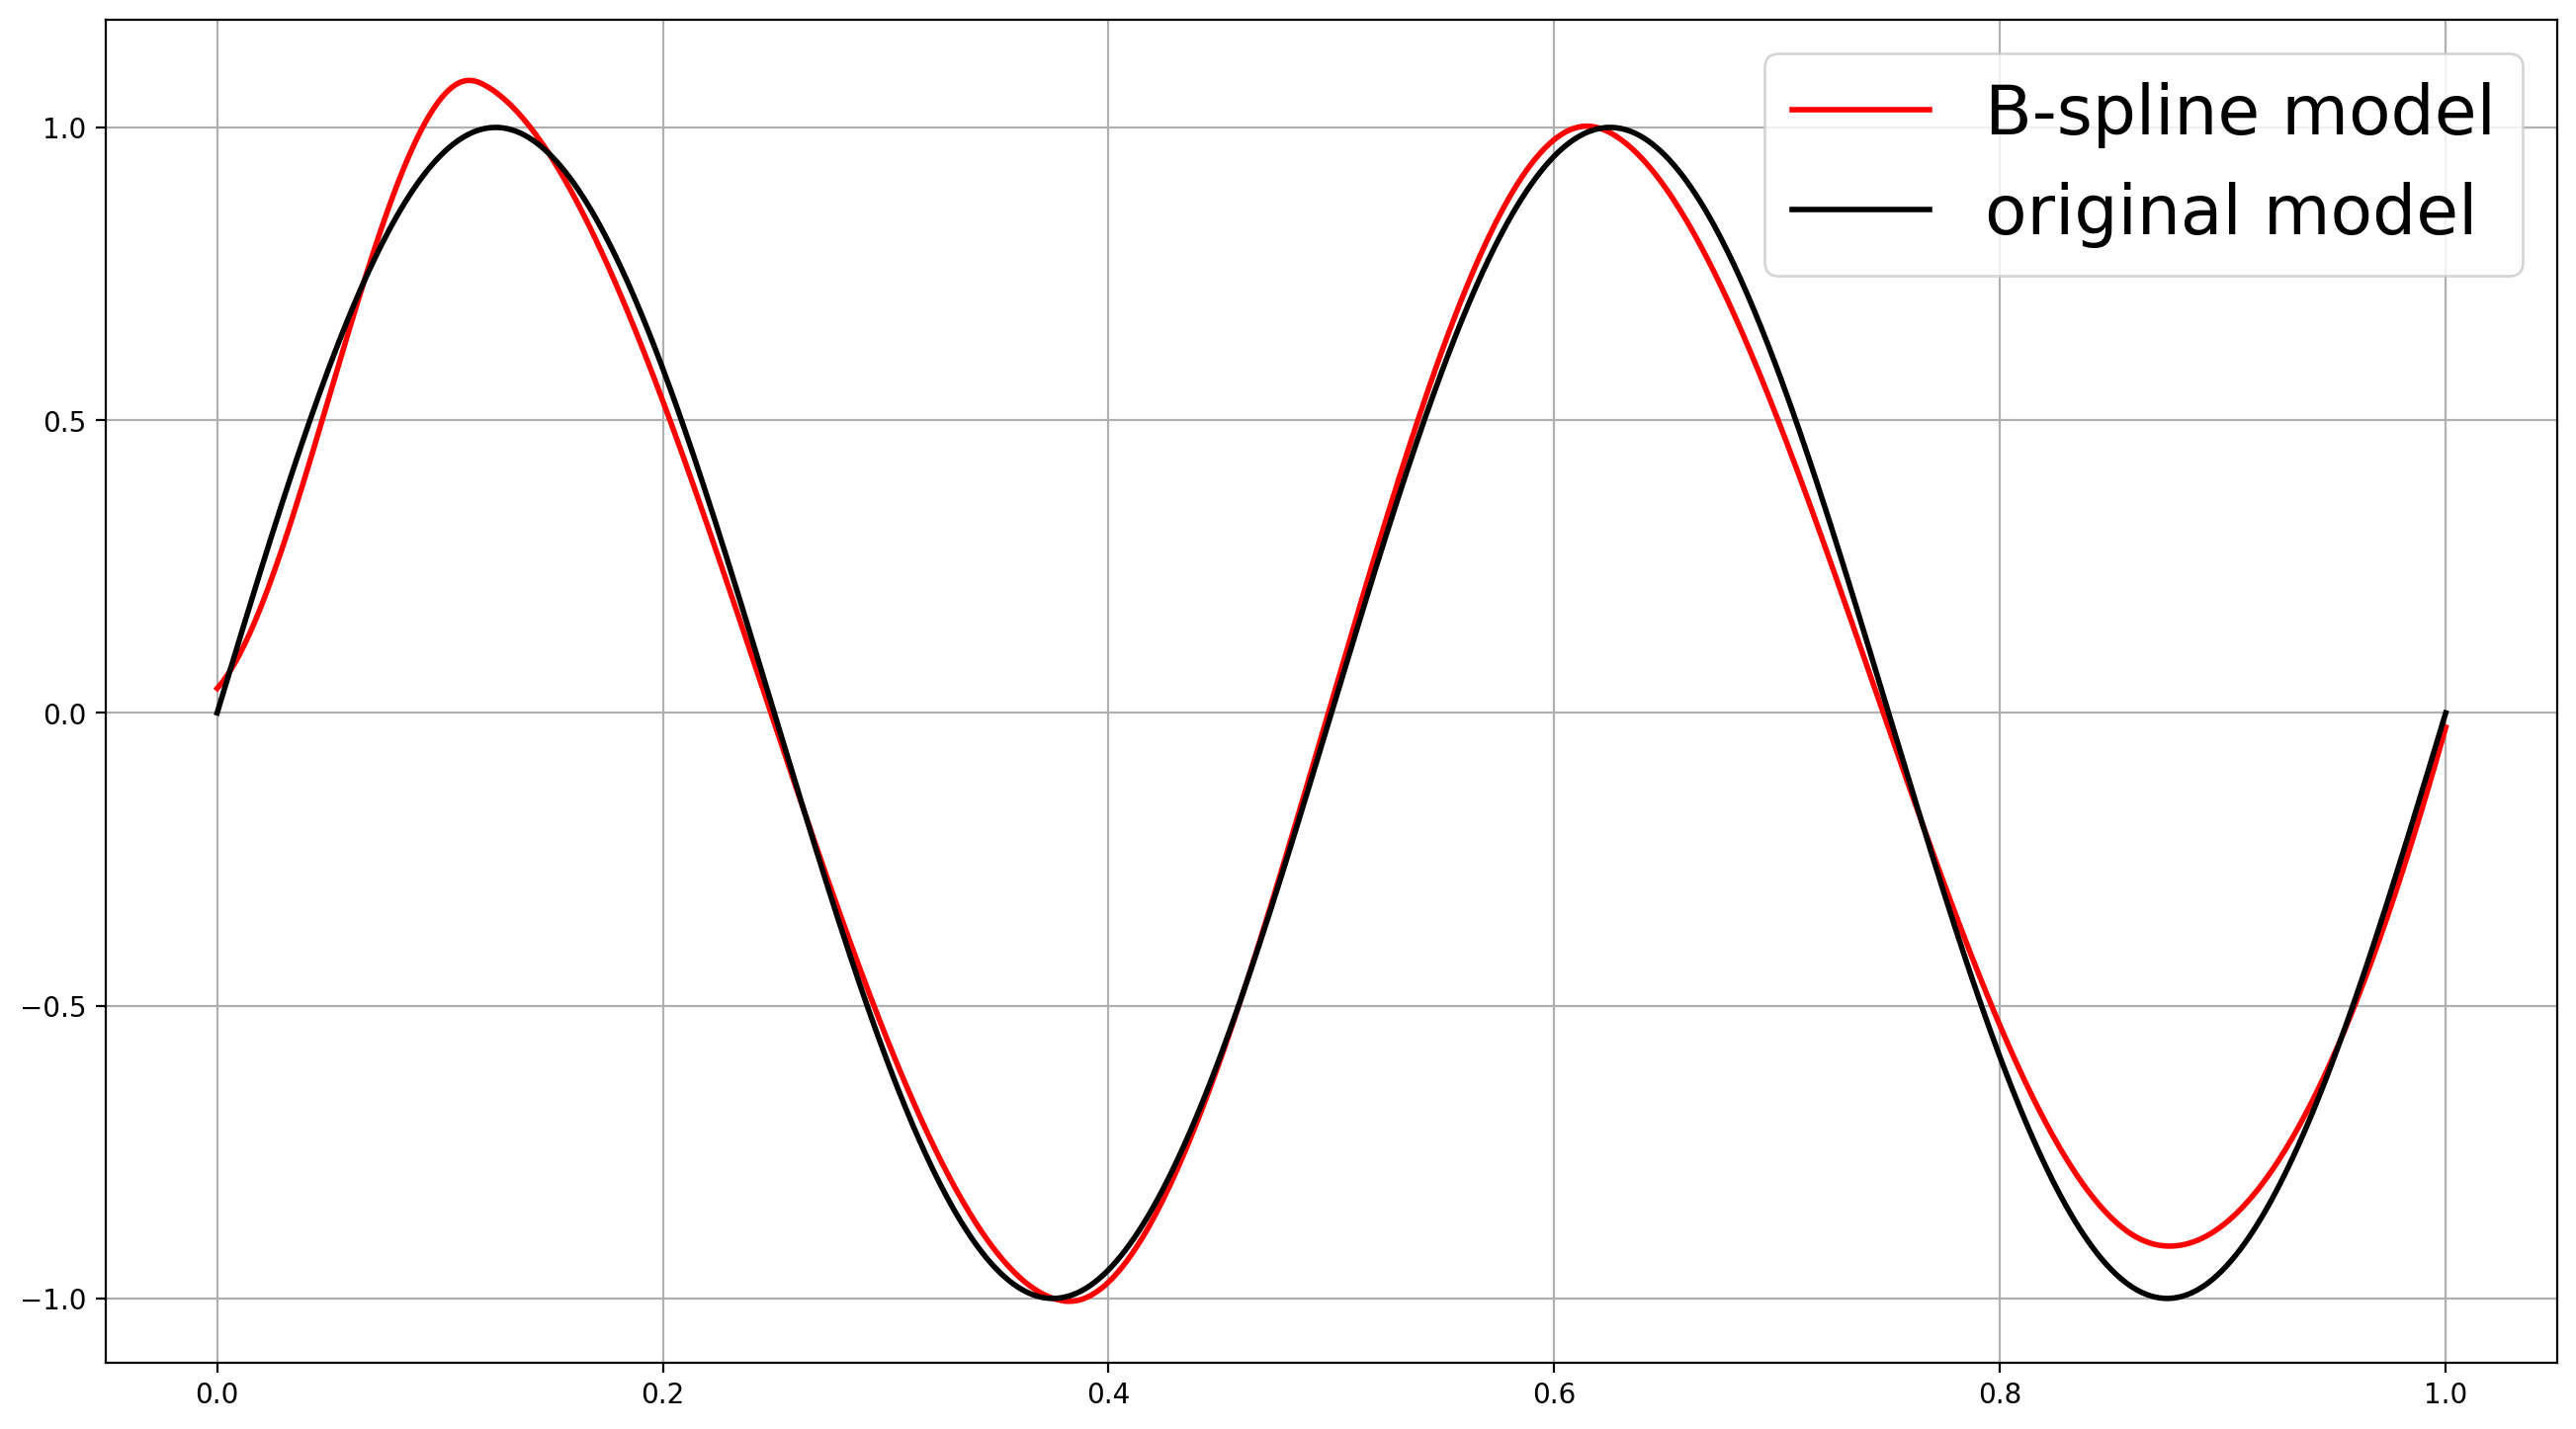

MSE:  0.08654651185028167


In [51]:
plt.figure(figsize=(16,9), dpi=200)
# plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result3, c="r", label="B-spline model", linewidth=2)
plt.plot(x, f(x), c="k", label="original model", linewidth=2)
plt.legend(fontsize=25)
plt.grid()
plt.show()
print("MSE: ", ((y_constrained_result3.reshape((-1,)) - y)**2).mean())

In [52]:
print("RSS: ", ((y_constrained_result3.reshape((-1,)) - f(x))**2).mean())

RSS:  0.002347199723835677


In [53]:
coef3 = compre_csr3.Solve_QP(deg=3, meq=4)
print("coef: ", coef3)
knots3 = compre_csr3.comprehensive_knots()
print("knots3: ", knots3)

coef:  [ 0.04168862  0.20031392  1.14307446  0.93450764 -0.96773238 -1.04179318
  1.13863832  0.8864247  -1.00081664 -0.78616307 -0.72236563  0.02805928]
knots3:  [0.11311, 0.12112, 0.37838, 0.38238, 0.61461, 0.62863, 0.86186, 0.88088]


In [54]:
def fhat3(w):
    bx = patsy.bs(x=w, knots=knots3, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef3
    return ans
def SE3(w):
    return (fhat3(w) - f(w))**2

In [55]:
ise3, _ = quad(SE3, 0, 1)
print("ISE: ", ise3)

ISE:  0.00342704597577276
